2024-10-31 18:41:05.948789: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Activities with >80% False motion_value:
PID: P06, Activity: FFSIT, Proportion of False: 1.00
PID: P11, Activity: FFSIT, Proportion of False: 0.96


/var/folders/xt/j055vd5n66x6nhkm2f0zzg2w0000gn/T/ipykernel_8261/460205791.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])


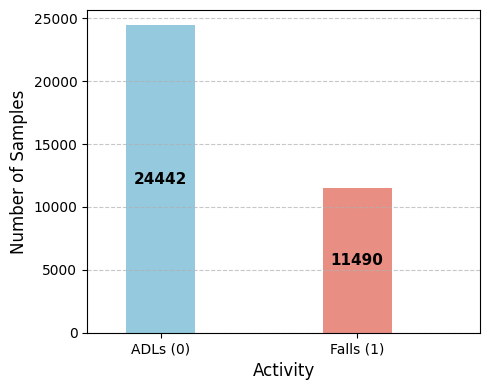

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, LSTM, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from imblearn.metrics import classification_report_imbalanced


def remove_zero_readings(df, threshold=10):
    """Remove records with zero readings above threshold."""
    # Track problematic sensor combinations
    zero_readings = pd.DataFrame()
    for sensor in ['breathingRate', 'heartRate']:
        zero_counts = df[df[sensor] == 0.0].groupby(['PID', 'activity_name'])[sensor].count()
        zero_readings = pd.concat([zero_readings, zero_counts[zero_counts > threshold]])
    
    # Remove identified problematic records
    outlier_indices = zero_readings.index.drop_duplicates()
    return df[~df.set_index(['PID', 'activity_name']).index.isin(outlier_indices)]
def plot_class_distribution(df):
    """
    Plot the distribution of ADLs (class=0) and Falls (class=1) with sample counts,
    with the count labels displayed inside the bars.
    """
    # Get the class distribution
    class_counts = df['class'].value_counts().reset_index()
    class_counts.columns = ['class', 'count']
    class_counts['label'] = class_counts['class'].apply(lambda x: 'ADLs (0)' if x == 0 else 'Falls (1)')

    # Plot the distribution using a bar plot with compact spacing
    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x='label', y='count', data=class_counts, palette=['skyblue', 'salmon'])

    # Adjust bar width and position them closer together
    for bar in ax.patches:
        bar.set_width(0.35)  # Set narrower bars
        bar.set_x(bar.get_x() + 0.1)  # Adjust position to bring bars closer

        # Add the labels inside the bars, centered both horizontally and vertically
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # Center horizontally
            bar.get_height() / 2,  # Center vertically
            f'{int(bar.get_height())}',  # Display the count value
            ha='center', va='center', fontsize=11, color='black', weight='bold'
        )
    # Align the x-axis labels with the bars
    ax.set_xticks([bar.get_x() + bar.get_width() / 2 for bar in ax.patches])
    ax.set_xticklabels(class_counts['label'])

    # Adjust the title with padding to avoid overlap with labels
    # ax.set_title("Distribution of ADLs and Falls", fontsize=14, weight='bold', pad=30)

    # Set labels and improve formatting
    ax.set_xlabel("Activity", fontsize=12)
    ax.set_ylabel("Number of Samples", fontsize=12)

    # Adjust y-axis limits with padding for better spacing
    ax.set_ylim(0, class_counts['count'].max() + class_counts['count'].max() * 0.05)

    # Add grid lines for clarity
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot with a tight layout
    plt.tight_layout()
    plt.show()


def show_activity_distribution(df, state='After Cleaning'):
    """
    Display and visualize the distribution of fall and ADL activities.
    """
    # Group by 'base_activity' and 'class' to count samples per activity
    activity_counts = df.groupby(['base_activity', 'class']).size().reset_index(name='sample_count')

    # Separate falls and ADLs for clearer visualization
    falls = activity_counts[activity_counts['base_activity'].isin(fall_activities)]
    adls = activity_counts[activity_counts['base_activity'].isin(non_fall_activities)]

    print(f"\n{state} - Falls Distribution:")
    print(falls)

    print(f"\n{state} - ADLs Distribution:")
    print(adls)
    
df = pd.read_csv("combined_sensor_data-all-7.csv")

# remove redundant 
df = df.drop(['targetDistance', 'AbsolutePressure'], axis=1)

# plot_class_distribution(df)

# feature engineering 
def combine_ambient(df, ambient_features):
    # Step 1: Select only ambient sensor features (CO2, Humidity, Noise, Pressure)
    ambient_df = df[ambient_features]

    # Step 2: Handle NaN values by filling with the mean
    ambient_df = ambient_df.fillna(ambient_df.mean())

    # Step 3: Standardize the ambient sensor features
    scaler = StandardScaler()
    ambient_features_scaled = scaler.fit_transform(ambient_df)
    # Step 4: Apply PCA to create the Environmental Index
    pca = PCA(n_components=1)  # Aggregate into a single component
    env_index = pca.fit_transform(ambient_features_scaled)
    # Add the Environmental Index to the original DataFrame
    df['environmental_index'] = env_index
    # Display the updated DataFrame
    # df.drop(ambient_features)
    # print(df.columns)
    df = df.drop(ambient_features, axis=1)
    return df


# Define the activities
fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]
non_fall_activities = ["LOB", "RS", "SBS", "SIT", "SSS", 'SSW', "SWW", "TWC", "WAT", 'WSS']
ambient_features = ['CO2', 'Humidity', 'Noise', 'Pressure']

def remove_low_motion_activities(df, threshold=0.8):
    """
    Print and remove fall activities where motion_value is False 
    for more than the threshold percentage of the activity's duration.
    """
    # List of fall activities to check
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Filter for fall activities only
    falls_df = df[df['activity_name'].isin(fall_activities)]

    # Calculate percentage of False motion values for each (PID, activity_name)
    motion_stats = (
        falls_df.groupby(['PID', 'activity_name'])['motion_value']
        .apply(lambda x: (x == False).mean())  # Calculate proportion of False values
    )

    # Identify activities to print and remove based on the threshold
    activities_to_remove = motion_stats[motion_stats > threshold]

    # Print the activity names and their proportions before removing
    print("Activities with >80% False motion_value:")
    for (pid, activity_name), proportion in activities_to_remove.items():
        print(f"PID: {pid}, Activity: {activity_name}, Proportion of False: {proportion:.2f}")

    # Remove identified activities from the DataFrame
    return df[~df.set_index(['PID', 'activity_name']).index.isin(activities_to_remove.index)]

def identify_and_remove_outliers_combined(df):
    """
    Identify outliers for both ADL and Fall activities using IQR and remove them from the dataset.
    Retain all other information and merge cleaned activities back.
    """
    # Group by base_activity, class, and PID to calculate the duration per activity
    duration_counts = df.groupby(['base_activity', 'class', 'PID']).size().reset_index(name='duration')

    # Separate ADLs and Falls
    adls = duration_counts[duration_counts['class'] == 0]  # ADL activities
    falls = duration_counts[duration_counts['class'] == 1]  # Fall activities

    # Helper function to identify and clean outliers using IQR
    def clean_outliers(data):
        outliers = []
        cleaned_data = []

        for activity in data['base_activity'].unique():
            activity_data = data[data['base_activity'] == activity]
            Q1 = activity_data['duration'].quantile(0.25)
            Q3 = activity_data['duration'].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers and non-outliers
            activity_outliers = activity_data[
                (activity_data['duration'] < lower_bound) | (activity_data['duration'] > upper_bound)
            ]
            activity_cleaned = activity_data[
                (activity_data['duration'] >= lower_bound) & (activity_data['duration'] <= upper_bound)
            ]

            outliers.append(activity_outliers)
            cleaned_data.append(activity_cleaned)

        # Combine all outliers and cleaned data
        all_outliers = pd.concat(outliers, ignore_index=True)
        all_cleaned_data = pd.concat(cleaned_data, ignore_index=True)

        return all_outliers, all_cleaned_data

    # Clean outliers for ADLs and Falls separately
    adl_outliers, cleaned_adls = clean_outliers(adls)
    fall_outliers, cleaned_falls = clean_outliers(falls)

    # Print identified outliers
    print("\nIdentified ADL Outliers:")
    print(adl_outliers[['base_activity', 'PID', 'duration']])

    print("\nIdentified Fall Outliers:")
    print(fall_outliers[['base_activity', 'PID', 'duration']])

    # Combine cleaned ADLs and Falls
    cleaned_df = pd.concat([cleaned_adls, cleaned_falls], ignore_index=True)

    # Merge cleaned activities with the original DataFrame to retain all columns
    final_df = df.merge(cleaned_df[['base_activity', 'PID']], on=['base_activity', 'PID'], how='inner')

    return final_df


# 2. Apply cleaning steps
df = remove_zero_readings(df)
df['motion_value'] = df['motion_value'].astype(int)
df = remove_low_motion_activities(df)
# df_2 = identify_and_remove_outliers_combined(df)

df_clean = df.drop(ambient_features, axis=1)
df_ambient = combine_ambient(df, ambient_features)

def filter_activities(df):
    # Define relevant fall activities
    fall_activities = ["FFAS", "FFT", "FWW", "FFTSIT", "FHO", "FFSIT"]

    # Define unique non-fall (ADL) activities (after removing trailing digits)
   
    # non_fall_activities = [
    #     "LOB", "RS", "SBS", "SIT", 'SSW', "SWW", "TWC", "WAT"
    # ]

    non_fall_activities = [
            "LOB", "RS", "SBS", 
            "SWW", "TWC", "WAT", 
            'WSS', 'SSW', 'SSS'
        ]

    # Filter the dataset to keep only relevant activities
    df_filtered = df[df['base_activity'].isin(fall_activities + non_fall_activities)]
    return df_filtered

final_df_clean = filter_activities(df_clean)
final_df_ambient = filter_activities(df_ambient)

plot_class_distribution(final_df_ambient)
# show_activity_distribution(final_df_ambient)
# final_df
# 19195/10583
# print(len(final_df_clean.columns)) # 14 features
# print(final_df_clean.columns) # 14 features
# print(final_df_ambient) # 14 features
# print(df_clean.columns) # 14 features with all ADLs

# print(df_clean.shape)
# print(final_df_clean.shape)
# Count unique fall activities
# fall_count = len(final_df_ambient[final_df_ambient['class'] == 1].groupby(['PID', 'activity_name']))
# print(f"Number of unique fall sequences: {fall_count}")

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [5]:
activity_counts = final_df_ambient.groupby(['base_activity', 'class']).size().reset_index(name='sample_count')

# Separate falls and ADLs for clearer visualization
falls = activity_counts[activity_counts['base_activity'].isin(fall_activities)]
adls = activity_counts[activity_counts['base_activity'].isin(non_fall_activities)]

print(" Falls Distribution:")
print(falls)

print("ADLs Distribution:")
print(adls)


 Falls Distribution:
  base_activity  class  sample_count
0          FFAS      1          2118
1         FFSIT      1          1274
2           FFT      1          2151
3        FFTSIT      1          1835
4           FHO      1          2187
5           FWW      1          1925
ADLs Distribution:
   base_activity  class  sample_count
6            LOB      0          6585
7             RS      0          1205
8            SBS      0          1658
9            SSS      0          3883
10           SSW      0          1373
11           SWW      0          2006
12           TWC      0          2695
13           WAT      0          2278
14           WSS      0          2759


                         motion_value     light      temp  breathingRate  \
motion_value                 1.000000  0.516330  0.009706       0.279606   
light                        0.516330  1.000000  0.061519       0.189833   
temp                         0.009706  0.061519  1.000000       0.040077   
breathingRate                0.279606  0.189833  0.040077       1.000000   
heartRate                    0.253199  0.229631  0.009654       0.724519   
physiologicalState           0.295769  0.202624  0.038153       0.127662   
targetDistance_filtered     -0.322145 -0.204058  0.043749      -0.181902   
health_idx                  -0.043170 -0.057219 -0.127536      -0.026728   
environmental_index          0.037137  0.198056  0.270652      -0.012603   

                         heartRate  physiologicalState  \
motion_value              0.253199            0.295769   
light                     0.229631            0.202624   
temp                      0.009654            0.038153   
breathi

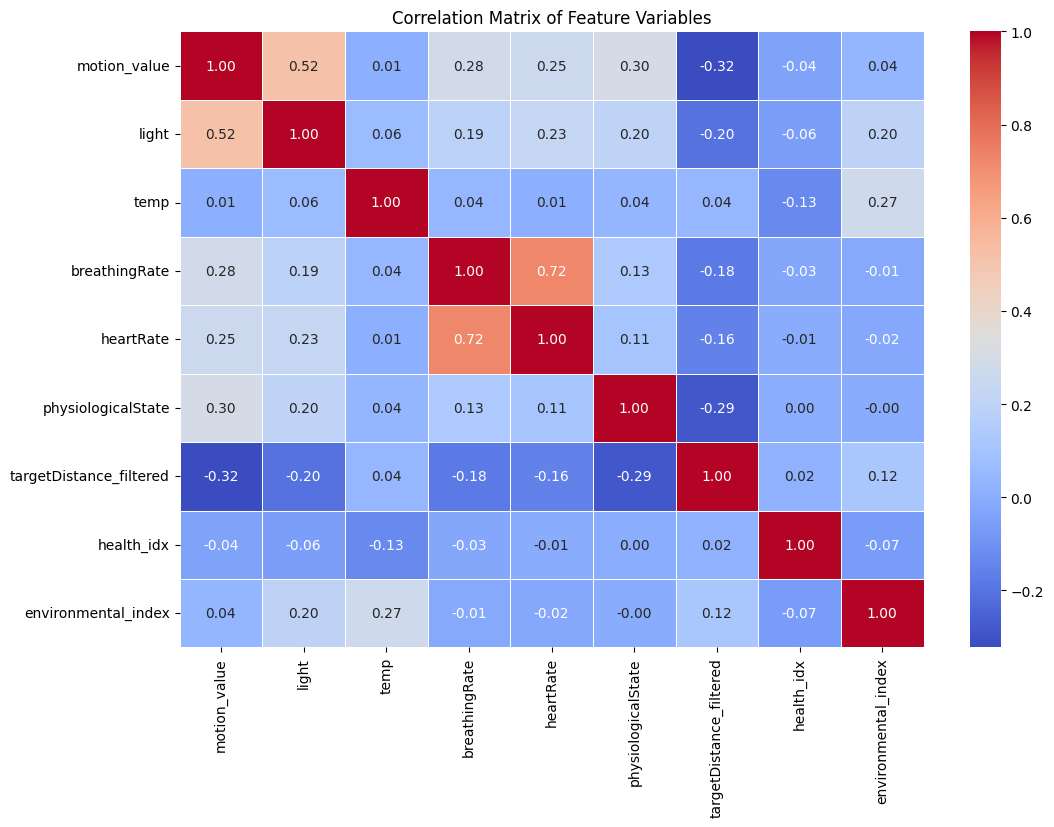

In [10]:
# Compute the correlation matrix
test_df = final_df_ambient.copy()
# print(test_df.columns)
test_df = test_df.drop(['timestamp', 'PID','activity_name', 'base_activity',  'class'], axis=1)
correlation_matrix = test_df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Plot the correlation matrix using a heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Feature Variables')
plt.show()

# start preprocessing

In [2]:
# Build the CNN model
def build_1d_cnn(input_shape, optimizer='adam', filters=64, kernel_size=3, l2_lambda=0.00001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape,
                     kernel_regularizer=l2(l2_lambda)))
    model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2)),
    model.add(Dense(1, activation='sigmoid'))  # Binary output

    # Compile the model with the custom weighted loss function
    model.compile(
        # loss=weighted_binary_crossentropy(weight_for_1=2.0),  # Higher weight for class 1
        loss=weighted_binary_crossentropy(weight_for_1=1.5),  # Higher weight for class 1
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model


from tensorflow.keras.layers import (
    Conv1D, Dense, Dropout, Flatten, MaxPooling1D,
    BatchNormalization, Activation
)




def build_1d_cnn_2(input_shape, optimizer='adam', filters=64, kernel_size=3, l2_lambda=0.00001):
    model = Sequential()
    
    # First Conv1D block
    model.add(Conv1D(filters=64, kernel_size=kernel_size,
                     input_shape=input_shape,
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())  # Added BatchNorm
    model.add(Activation('relu'))    # Activation moved after BatchNorm
    
    # Second Conv1D block
    model.add(Conv1D(filters=64, kernel_size=kernel_size,
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())  # Added BatchNorm
    model.add(Activation('relu'))    # Activation moved after BatchNorm
    
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # Dense layer block
    model.add(Dense(100))
    model.add(BatchNormalization())  # Added BatchNorm
    model.add(Activation('relu'))    # Activation moved after BatchNorm
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    # Compile the model with the custom weighted loss function
    model.compile(
        loss=weighted_binary_crossentropy(weight_for_1=1.5),
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model


In [3]:

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn
def create_sliding_windows2(data, window_size=11, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)
        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window
    return np.array(windows), np.array(labels)

def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)

import tempfile

from keras import models, layers
from PIL import ImageFont
def visualise_model1(name): 
    windows_test, labels_test = create_sliding_windows2(final_df_ambient, window_size=11, step_size=1) 
    X_train, X_test, y_train, y_test = train_test_split(
        windows_test, 
        labels_test, 
        test_size=0.2, 
        random_state=42, 
        stratify=labels_test
    ) 
    
    # Build the CNN model 
    input_shape = (X_train.shape[1], X_train.shape[2]) 
    
    # Using Sequential model with keras layers
    model = models.Sequential([
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
        
    ])
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # First, let's see the text summary
    print("\nModel Summary:")
    model.summary()
    
    # Try to create the plot
    try:
        # Make sure directory exists
        os.makedirs('model_plots', exist_ok=True)
        
        # Create the plot
        plot_model(
            model,
            to_file=f'model_plots/{name}.png',
            show_shapes=True,
            show_layer_names=True,
            rankdir='TB'
        )
        print(f"\nModel visualization saved to model_plots/{name}.png")
    except Exception as e:
        print(f"\nError creating visualization: {e}")
        print("\nTry installing graphviz:")
        print("brew install graphviz")
        print("pip install graphviz pydot")
    
    return model, X_train, X_test, y_train, y_test
    
# Example usage
model, X_train, X_test, y_train, y_test = visualise_model1('my_model')



Model Summary:


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 9, 64)          │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,210 (39.88 KB)

 Trainable params: 10,210 (39.88 KB)

 Non-trainable params: 0 (0.00 B)


Model visualization saved to model_plots/my_model.png


In [4]:
from sklearn.metrics import classification_report
import tensorflow.keras.backend as K
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from imblearn.over_sampling import ADASYN
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# plt.style.use('classic')

def plot_advanced_metrics(y_test, y_pred_probs, model_name="CNN Model"):
    """
    Create publication-quality ROC and Precision-Recall curves
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'{model_name} ROC Curve')
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # 2. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    avg_precision = average_precision_score(y_test, y_pred_probs)
    
    ax2.plot(recall, precision, color='darkgreen', lw=2,
             label=f'PR curve (AP = {avg_precision:.3f})')
    ax2.axhline(y=np.sum(y_test)/len(y_test), color='navy', lw=2, linestyle='--',
                label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'{model_name} Precision-Recall Curve')
    ax2.legend(loc="lower left")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    # plt.tight_layout()
    # plt.savefig('advanced_metrics.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return roc_auc, avg_precision

def analyze_threshold_impact(y_test, y_pred_probs):
    """
    Analyze impact of different classification thresholds using numpy operations
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        
        # Calculate confusion matrix elements using numpy
        tn = np.sum(np.logical_and(y_test == 0, y_pred == 0))
        fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
        fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))
        tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    # Plot threshold impact
    plt.figure(figsize=(10, 6))
    thresholds = [r['threshold'] for r in results]
    plt.plot(thresholds, [r['precision'] for r in results], 
             label='Precision', marker='o')
    plt.plot(thresholds, [r['recall'] for r in results], 
             label='Recall', marker='s')
    plt.plot(thresholds, [r['f1'] for r in results], 
             label='F1-score', marker='^')
    plt.xlabel('Classification Threshold')
    plt.ylabel('Score')
    plt.title('Impact of Classification Threshold on Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.tight_layout()
    # plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
    # plt.close()
    
    return results

def find_optimal_threshold(results):
    """Find threshold with highest F1 score"""
    return max(results, key=lambda x: x['f1'])['threshold']

def format_threshold_results(results):
    """Format threshold results as string"""
    text = ""
    for r in results:
        text += f"\n   Threshold {r['threshold']:.1f}:"
        text += f" Precision={r['precision']:.3f},"
        text += f" Recall={r['recall']:.3f},"
        text += f" F1={r['f1']:.3f}"
    return text

def evaluate_model_advanced(model, X_test, y_test):
    """
    Main function to generate all advanced metrics
    """
    # Get predictions and ensure they're the right shape
    y_pred_probs = model.predict(X_test, verbose=0)
    if len(y_pred_probs.shape) > 1 and y_pred_probs.shape[1] == 1:
        y_pred_probs = y_pred_probs.ravel()
    
    # Generate ROC and PR curves
    roc_auc, avg_precision = plot_advanced_metrics(y_test, y_pred_probs)
    
    # Analyze threshold impact
    threshold_results = analyze_threshold_impact(y_test, y_pred_probs)
    
    # Generate summary
    summary = f"""
    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): {roc_auc:.4f}

    2. Precision-Recall Analysis:
    - Average Precision (AP): {avg_precision:.4f}

    3. Threshold Analysis:
    Optimal threshold based on F1-score: {find_optimal_threshold(threshold_results):.2f}
    
    Performance at different thresholds:
    {format_threshold_results(threshold_results)}
    """
    
    print(summary)
    return roc_auc, avg_precision, threshold_results


def create_sliding_windows(data, window_size=8, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)
    # features_df = features_df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors to NaN
    # features_df = features_df.fillna(0)

    print(features_df) 
    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)

        # Handle any NaN values resulting from coercion
        group = group.fillna(0)  # Replace NaN values with 0 or use other imputation methods

        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window

    return np.array(windows), np.array(labels)

def create_sliding_windows_normal(data, window_size=8, step_size=1):
    """Create sliding windows across the entire dataset without grouping."""
    windows = []
    labels = []
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Iterate through the dataset to create sliding windows
    for i in range(0, len(features_df) - window_size + 1, step_size):
        # Extract a window of features and normalize it
        window = features_df.iloc[i:i + window_size].values
        normalized_window = normalize_window(window)

        # Store the normalized window and corresponding label (from 'class' column)
        windows.append(normalized_window)
        labels.append(data['class'].iloc[i + window_size - 1])  # Label corresponds to the last row in the window

    return np.array(windows), np.array(labels)


def create_sliding_windows_activity(data, window_size=10, step_size=1):
    """Create sliding windows within each activity group."""
    windows = []
    labels = []
    features = data.drop(['class', 'activity_name', 'timestamp', 'PID', 'base_activity'], axis=1).columns

    for _, group in data.groupby(['activity_name', 'PID']):
        group = group.reset_index(drop=True)
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]
            windows.append(window[features].values)
            labels.append(window['class'].mode()[0])
    
    return np.array(windows), np.array(labels)

# new
def create_sliding_windows2(data, window_size=11, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)
        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].mode()[0])  # Assign the most frequent class in the window
    return np.array(windows), np.array(labels)

# new with pid 
def create_sliding_windows_pid(data, window_size=10, step_size=1):
    """Create sliding windows within each activity, ensuring activities are not mixed."""
    windows = []
    labels = []
    window_pids = []  # New list to store PIDs

    # Extract feature columns and ensure they are numeric
    features_df = data.drop(['timestamp', 'class', 'activity_name', 'base_activity', 'PID'], axis=1)

    # Group by participant and activity to maintain boundaries
    for _, group in data.groupby(['PID', 'activity_name']):
        group = group.reset_index(drop=True)
        pid = group['PID'].iloc[0]  # Get PID for this group

        # Only process windows of the desired size
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]

            # Normalize the window
            normalized_window = normalize_window(window[features_df.columns].values)

            windows.append(normalized_window)
            labels.append(window['class'].iloc[0])  # First class value (since they're all same in the activity)
            window_pids.append(pid)  # Store PID for this window
            
    return np.array(windows), np.array(labels), np.array(window_pids)

def normalize_window(window):
    """Normalize each sliding window independently (channel-wise)."""
    epsilon = 1e-10  # To prevent division by zero
    mean = window.mean(axis=0)  # Mean per feature
    std = window.std(axis=0)  # Std per feature
    return (window - mean) / (std + epsilon)


def apply_ros(X_train, y_train):
    """
    Apply Random OverSampling (ROS) to balance the dataset.
    """
    ros = RandomOverSampler(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape for ROS
    X_resampled, y_resampled = ros.fit_resample(X_train_reshaped, y_train)
    print(f"Data after ROS: {X_resampled.shape[0]} samples")
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = smote.fit_resample(X_train_reshaped, y_train)
    print(f"Data after SMOTE: {X_resampled.shape[0]} samples")

    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

def apply_adasyn(X_train, y_train):
    adasyn = ADASYN(random_state=42)
    # Reshape the data for ADASYN (flatten each sample into 2D for the algorithm)
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_resampled, y_resampled = adasyn.fit_resample(X_train_reshaped, y_train)
    
    print(f"Data after ADASYN: {X_resampled.shape[0]} samples")
    
    # Reshape back to the original shape of X_train
    return X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2]), y_resampled

# old
def apply_mu_sigma(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate standard deviation of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's standard deviation
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # Shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


def apply_gan_augmentation(X_train, y_train, num_samples=8618, noise_dim=100, hidden_dim=64, num_epochs=100):
    """
    Generate synthetic time-series data using a GAN and augment the training set.
    
    Parameters:
    - X_train: Original training data (features)
    - y_train: Original training labels
    - num_samples: Number of synthetic sequences to generate
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X_augmented: Augmented feature set (X_train + synthetic samples)
    - y_augmented: Augmented labels set (y_train + synthetic labels)
    """

    # Get sequence length from X_train (assume [n_samples, seq_len, features])
    seq_len = X_train.shape[1]
    feature_dim = X_train.shape[2]

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len * feature_dim)
    discriminator = Discriminator(seq_len * feature_dim, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_data = torch.tensor(X_train[idx].reshape(batch_size, -1), dtype=torch.float32)
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()
    synthetic_data = synthetic_data.reshape(num_samples, seq_len, feature_dim)

    # Create synthetic labels (1 for falls or any minority class, as needed)
    synthetic_labels = np.ones(num_samples)

    # Concatenate synthetic data with original training data
    X_augmented = np.concatenate((X_train, synthetic_data), axis=0)
    y_augmented = np.concatenate((y_train, synthetic_labels), axis=0)

    return X_augmented, y_augmented


def weighted_binary_crossentropy(weight_for_1):
    """
    Custom weighted binary cross-entropy loss.
    weight_for_1: Weight for positive class (falls, class = 1).
    """
    def loss_fn(y_true, y_pred):
        # Compute the standard binary cross-entropy loss
        bce = K.binary_crossentropy(y_true, y_pred)

        # Apply weights: higher weight for class 1 (falls)
        weight_vector = y_true * weight_for_1 + (1. - y_true) * 1.0  # Class 0 gets weight 1.0

        # Return the weighted loss
        return K.mean(weight_vector * bce)

    return loss_fn


def print_window_dataset_info(X, y, stage=""):
    """
    Print detailed information about windowed dataset
    """
    print(f"\n{'='*20} {stage} {'='*20}")
    print(f"current n_window size {len(X)}")
    print(f"Dataset shape: {X.shape}")  # (n_samples, window_size, n_features)
    print(f"Labels shape: {y.shape}")   # (n_samples,)
    
    # Class distribution
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    print("\nClass Distribution:")
    print("-----------------")
    for class_label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")


def get_all_metrics(model, X_test, y_test, model_name, threshold=0.5):  # made threshold a parameter
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)  # use the threshold parameter
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"######## Confusion matrix for {model_name} model (threshold={threshold}) ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")
    
    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return metrics


def group_kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
    # Generate sliding windows and labels, now also keeping track of PIDs
    # windows, labels, pids = create_sliding_windows_pid(data, window_size=window_size, step_size=step_size)
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)
    pids = []
    for _, group in data.groupby(['PID', 'activity_name']):
        pid = group['PID'].iloc[0]
        n_windows = len(group) - window_size + 1
        pids.extend([pid] * n_windows)
    pids = np.array(pids)
    
    # First split maintaining group structure
    unique_pids = np.unique(pids)
    # Using GroupShuffleSplit for train/test split to maintain participant separation
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(windows, labels, groups=pids))
    
    X_train, X_test = windows[train_idx], windows[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    pids_train, pids_test = pids[train_idx], pids[test_idx]
    
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    print(f"Training participants: {len(np.unique(pids_train))}, Test participants: {len(np.unique(pids_test))}")
    
    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Apply augmentation if specified
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        # Replicate the PIDs after augmentation to match the new samples
        # pids_train_resampled = np.repeat(pids_train, len(X_train_resampled) // len(X_train))
        unique_pids = np.unique(pids_train)
        augmented_size = len(X_train_resampled)
        pids_per_class = {
            label: pids_train[y_train == label] for label in np.unique(y_train)
        }
        pids_train_resampled = []
        for label in np.unique(y_train_resampled):
            label_count = np.sum(y_train_resampled == label)
            label_pids = np.tile(pids_per_class[label], 
                               int(np.ceil(label_count / len(pids_per_class[label]))))
            pids_train_resampled.extend(label_pids[:label_count])
        pids_train_resampled = np.array(pids_train_resampled)
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        pids_train_resampled = pids_train
    
    print_window_dataset_info(X_train_resampled, y_train_resampled, 
                            f"Training Set After {augmentation_fn.__name__ if augmentation_fn else 'No'} Augmentation")
    assert len(X_train_resampled) == len(y_train_resampled) == len(pids_train_resampled), "Mismatch in lengths after augmentation"
    
    # GroupKFold cross-validation
    group_kfold = GroupKFold(n_splits=n_splits)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train_resampled, 
                                                                 y_train_resampled, 
                                                                 groups=pids_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print(f"Validation participants: {np.unique(pids_train_resampled[val_idx])}")
        
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
            
        print(f"Fold {fold + 1} validation accuracy: {val_acc:.4f}")
    
    # Evaluate best model on test set
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nTest Set Participants:", np.unique(pids_test))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history

from sklearn.manifold import TSNE

def visualize_tsne(original_data, augmented_data):
    # Combine the original and augmented data for visualization
    combined_data = np.vstack((original_data, augmented_data))
    
    # Apply t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(combined_data)
    
    # Plot the data
    plt.scatter(reduced_data[:len(original_data), 0], reduced_data[:len(original_data), 1], label='Original Data', alpha=0.7)
    plt.scatter(reduced_data[len(original_data):, 0], reduced_data[len(original_data):, 1], label='Augmented Data', alpha=0.7)
    plt.legend()
    plt.show()


from tensorflow.keras.utils import plot_model

def visualise_model(model, name):
    # Plot the model and save as PNG
    plot_model(model, to_file=f'resnet_model_{name}.png', show_shapes=True, show_layer_names=True)
    # Display the plot
    img = plt.imread(f'resnet_model_{name}.png')
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
# Visualize the augmented data with t-SNE
# visualize_tsne(X, augmented_X)

# augmentation_fn -> mu-sigma
# second_aug_fn -> smote/ros/adasyn
def kfold_model_performance(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, 
                            window_size=11, step_size=1, n_splits=5, epochs=100, view_aug=False):
    
    # Preprocess data
    # Step 2: Generate sliding windows and labels
    windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    print("using stratify=labels")
    X_train, X_test, y_train, y_test = train_test_split(
        windows, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    if (view_aug):
        visualize_tsne(X_train, X_train_resampled)
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    

    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        print(f"input shape: {input_shape}")
        
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred, average='weighted'),
        'recall': recall_score(y_test, y_test_pred, average='weighted'),
        'f1': f1_score(y_test, y_test_pred, average='weighted')
    }

    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history, y_test, y_test_pred



def kfold_model_performance_strat(data, build_model_fn=None, augmentation_fn=None, second_aug_fn=None, gan_fn=None, window_size=11, step_size=1, n_splits=5, epochs=100):
    train_data, test_data = train_test_split(
        data, test_size=0.2, random_state=42, stratify=data['class']
    )

    X_train_windows, y_train = create_sliding_windows2(train_data, window_size=window_size, step_size=step_size)
    X_test_windows, y_test = create_sliding_windows2(test_data, window_size=window_size, step_size=step_size)

    scaler = MinMaxScaler()
    X_train_windows = scaler.fit_transform(X_train_windows.reshape(-1, X_train_windows.shape[-1])).reshape(X_train_windows.shape)
    X_test = scaler.transform(X_test_windows.reshape(-1, X_test_windows.shape[-1])).reshape(X_test_windows.shape)

    # Preprocess data
    # Step 2: Generate sliding windows and labels
    # windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

    # print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
    # X_train, X_test, y_train, y_test = train_test_split(
    #     windows, labels, test_size=0.2, random_state=42, stratify=labels
    # )
    print(f"Training set shape: {X_train_windows.shape}, Test set shape: {X_test.shape}")

    print_window_dataset_info(X_train_windows, y_train, "Training Set Before Augmentation")

    # Step 4: Apply oversampling (ROS or SMOTE) on the training data only 
    if augmentation_fn:
        X_train_resampled, y_train_resampled = augmentation_fn(X_train_windows, y_train)
        desc =  f"Training Set After {augmentation_fn.__name__}"
    else:
        X_train_resampled, y_train_resampled = X_train_windows, y_train
        desc = "Training set: NO Sampling"
        
    if second_aug_fn:
        X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After {second_aug_fn.__name__}"
    
    if gan_fn:
        X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
        desc =  f"Training Set After GAN: {gan_fn.__name__}"
        
    print_window_dataset_info(X_train_resampled, y_train_resampled, desc)
    
    # Stratified k-fold cross-validation
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
    test_metrics = None
    best_model = None
    best_val_score = 0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
        print(f"\nFold {fold + 1}/{n_splits}")
        X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
        y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

        # Step 5: Build and compile the 1D CNN model
        input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
        model = build_model_fn(input_shape=input_shape)
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=epochs,
            batch_size=32,
            # callbacks=[EarlyStopping(patience=5)],
            verbose=1
        )
        
        y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
        val_acc = accuracy_score(y_fold_val, y_val_pred)
        
        cv_scores['accuracy'].append(val_acc)
        cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
        cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
        cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))
        
        if val_acc > best_val_score:
            best_val_score = val_acc
            best_model = model
    
    roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
    thres = find_optimal_threshold(threshold_results)

    y_test_pred = (best_model.predict(X_test) > thres).astype(int)
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred)
    }
    
    print("\nCross-Validation Results:")
    for metric in cv_scores:
        mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
        print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")
    
    print("\nTest Set Results (Best Model):")
    for metric, value in test_metrics.items():
        print(f"{metric.title()}: {value:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\nClassification Report (Imbalanced):")
    print(classification_report_imbalanced(y_test, y_test_pred))
    return cv_scores, test_metrics, best_model, history



# df_clean-> no ADLs removed (more imbalanced)
# cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1 = kfold_model_performance(
#     df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# cv_scores_g, test_scores_g, best_cnn_model_g, history_model_g = group_kfold_model_performance(
#     df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
#     window_size=11, step_size=1
# )

# df_clean
Test Set Results (Best Model):
Accuracy: 0.8464
Precision: 0.6821
Recall: 0.7370
F1: 0.7085

Confusion Matrix:
[[3497  461]
 [ 353  989]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      3958
           1       0.68      0.74      0.71      1342

    accuracy                           0.85      5300
   macro avg       0.80      0.81      0.80      5300
weighted avg       0.85      0.85      0.85      5300


# final_df_clean -> not as imbalanced as df_clean
Cross-Validation Results:
Accuracy: 0.8945 ± 0.0035
Precision: 0.8656 ± 0.0110
Recall: 0.9345 ± 0.0133
F1: 0.8986 ± 0.0032

Test Set Results (Best Model):
Accuracy: 0.8447
Precision: 0.7222
Recall: 0.7471
F1: 0.7345

Confusion Matrix:
[[3049  400]
 [ 352 1040]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3449
           1       0.72      0.75      0.73      1392

    accuracy                           0.84      4841
   macro avg       0.81      0.82      0.81      4841
weighted avg       0.85      0.84      0.85      4841



# df_ambient -> with ambient information (but very imbalanced)
Cross-Validation Results:
Accuracy: 0.8982 ± 0.0092
Precision: 0.8594 ± 0.0192
Recall: 0.9530 ± 0.0084
F1: 0.9036 ± 0.0070

Test Set Results (Best Model):
Accuracy: 0.8564
Precision: 0.7183
Recall: 0.7124
F1: 0.7153

Confusion Matrix:
[[3583  375]
 [ 386  956]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3958
           1       0.72      0.71      0.72      1342

    accuracy                           0.86      5300
   macro avg       0.81      0.81      0.81      5300
weighted avg       0.86      0.86      0.86      5300

In [5]:
# final_df_clean -> not as imbalanced as df_clean
# if performance not as good, then use df_clean . then compare df_ambient and df_clean

# final_df_ambient -> removed one adl, and with context info (env_index)
cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after SMOTE: 27978 samples

==================== Training Set After apply_smote ====================
current n_window size 27978
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5
input shape: (11, 9)


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5303 - loss: 0.8294 - val_accuracy: 0.6271 - val_loss: 0.7673
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6323 - loss: 0.7686 - val_accuracy: 0.6546 - val_loss: 0.7300
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6558 - loss: 0.7357 - val_accuracy: 0.6792 - val_loss: 0.7029
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6854 - loss: 0.7019 - val_accuracy: 0.7234 - val_loss: 0.6735
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7057 - loss: 0.6706 - val_accuracy: 0.7343 - val_loss: 0.6455
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7355 - loss: 0.6382 - val_accuracy: 0.7412 - val_loss: 0.6203
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7455 - loss: 0.6190 - val_accuracy: 0.7550 - val_loss: 0.5970
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7493 - loss: 0.6028 - val_accu

KeyboardInterrupt: 

using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after SMOTE: 27978 samples

==================== Training Set After apply_smote ====================
current n_window size 27978
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5459 - loss: 0.8246 - val_accuracy: 0.6240 - val_loss: 0.7835
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6280 - loss: 0.7695 - val_accuracy: 0.6769 - val_loss: 0.7453
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6604 - loss: 0.7326 - val_accuracy: 0.6850 - val_loss: 0.6921
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6897 - loss: 0.6969 - val_accuracy: 0.7091 - val_loss: 0.6686
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7191 - loss: 0.6618 - val_accuracy: 0.7143 - val_loss: 0.6393
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7314 - loss: 0.6338 - val_accuracy: 0.7654 - val_loss: 0.6087
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7511 - loss: 0.6092 - val_accuracy: 0.7647 - val_loss: 0.6003
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7623 - loss: 0.5872 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5501 - loss: 0.8260 - val_accuracy: 0.6394 - val_loss: 0.7712
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6264 - loss: 0.7697 - val_accuracy: 0.6791 - val_loss: 0.7382
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6587 - loss: 0.7338 - val_accuracy: 0.6980 - val_loss: 0.7168
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6838 - loss: 0.7078 - val_accuracy: 0.6909 - val_loss: 0.6740
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7142 - loss: 0.6685 - val_accuracy: 0.7327 - val_loss: 0.6342
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7254 - loss: 0.6445 - val_accuracy: 0.7445 - val_loss: 0.6200
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7408 - loss: 0.6198 - val_accuracy: 0.7402 - val_loss: 0.6017
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7526 - loss: 0.5935 - val_accuracy: 0.7789

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5479 - loss: 0.8224 - val_accuracy: 0.5538 - val_loss: 0.7884
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6224 - loss: 0.7656 - val_accuracy: 0.6690 - val_loss: 0.7297
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6751 - loss: 0.7252 - val_accuracy: 0.6919 - val_loss: 0.6993
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6929 - loss: 0.6966 - val_accuracy: 0.6696 - val_loss: 0.6859
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7141 - loss: 0.6623 - val_accuracy: 0.7391 - val_loss: 0.6488
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7371 - loss: 0.6270 - val_accuracy: 0.7325 - val_loss: 0.6174
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7580 - loss: 0.5975 - val_accuracy: 0.7439 - val_loss: 0.6004
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7621 - loss: 0.5826 - val_accuracy: 0.7513

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5390 - loss: 0.8252 - val_accuracy: 0.6261 - val_loss: 0.7679
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6326 - loss: 0.7632 - val_accuracy: 0.6647 - val_loss: 0.7390
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6655 - loss: 0.7299 - val_accuracy: 0.6710 - val_loss: 0.7075
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6828 - loss: 0.7039 - val_accuracy: 0.7162 - val_loss: 0.6794
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7022 - loss: 0.6833 - val_accuracy: 0.6945 - val_loss: 0.6644
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7220 - loss: 0.6506 - val_accuracy: 0.7340 - val_loss: 0.6358
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7480 - loss: 0.6205 - val_accuracy: 0.7105 - val_loss: 0.6350
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7494 - loss: 0.5996 - val_accuracy: 0.7478

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5414 - loss: 0.8260 - val_accuracy: 0.5868 - val_loss: 0.7799
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6279 - loss: 0.7697 - val_accuracy: 0.6786 - val_loss: 0.7574
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6595 - loss: 0.7360 - val_accuracy: 0.6781 - val_loss: 0.7086
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6942 - loss: 0.6915 - val_accuracy: 0.7135 - val_loss: 0.6818
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7168 - loss: 0.6588 - val_accuracy: 0.7119 - val_loss: 0.6517
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7355 - loss: 0.6307 - val_accuracy: 0.7512 - val_loss: 0.6223
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7466 - loss: 0.6100 - val_accuracy: 0.7462 - val_loss: 0.6000
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7557 - loss: 0.5901 - val_accuracy: 0.7430

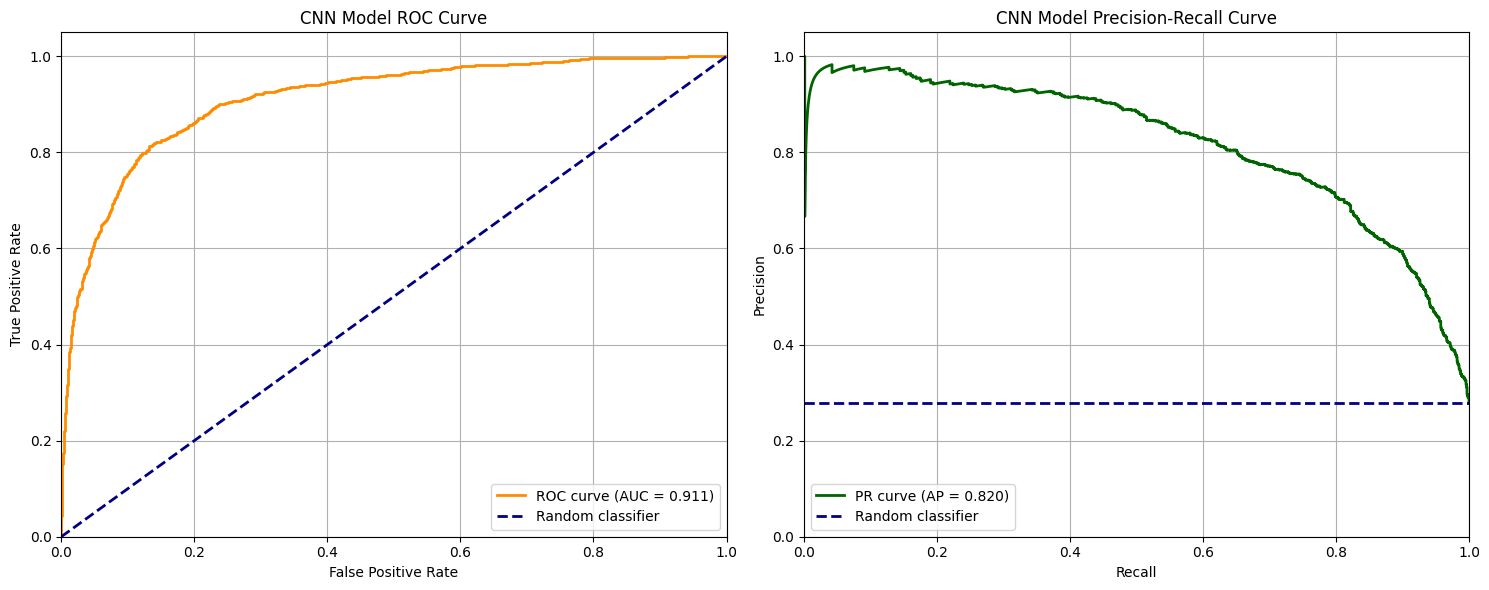

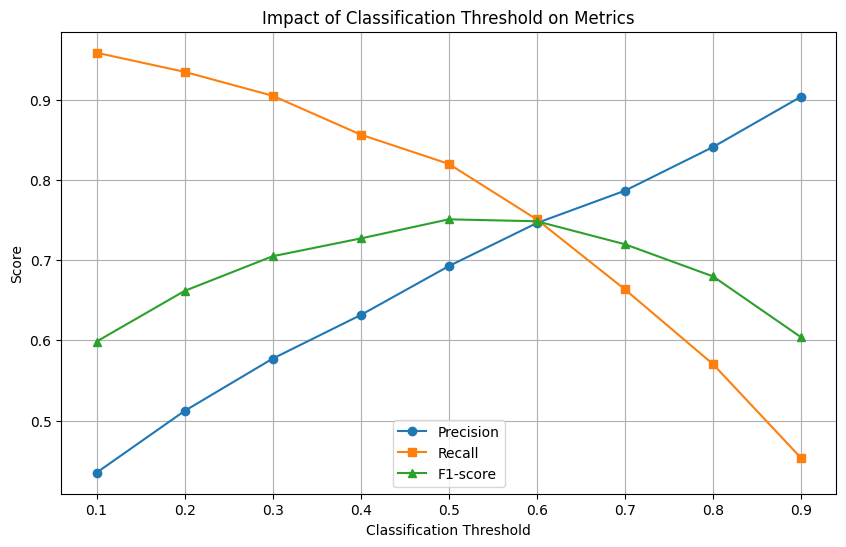


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9113

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8199

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.435, Recall=0.958, F1=0.598
   Threshold 0.2: Precision=0.512, Recall=0.934, F1=0.662
   Threshold 0.3: Precision=0.577, Recall=0.905, F1=0.705
   Threshold 0.4: Precision=0.632, Recall=0.856, F1=0.727
   Threshold 0.5: Precision=0.692, Recall=0.820, F1=0.751
   Threshold 0.6: Precision=0.746, Recall=0.751, F1=0.748
   Threshold 0.7: Precision=0.786, Recall=0.663, F1=0.720
   Threshold 0.8: Precision=0.841, Recall=0.570, F1=0.680
   Threshold 0.9: Precision=0.904, Recall=0.453, F1=0.604
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


TypeError: got an unexpected keyword argument 'average'

In [ ]:

#### change to wegihted (updated) # dont use 
cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1, y_test_model1, y_test_pred_model1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
    window_size=11, step_size=1
)

using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After apply_mu_sigma_new ====================
current n_window size 30102
Dataset shape: (30102, 11, 9)
Labels shape: (30102,)

Class Distribution:
-----------------
Class 0: 13989 samples (46.47%)
Class 1: 16113 samples (53.53%)

Fold 1/5
Epoch 1/100


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6829 - loss: 0.6131 - val_accuracy: 0.8371 - val_loss: 0.4527
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8159 - loss: 0.4631 - val_accuracy: 0.8397 - val_loss: 0.4363
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8325 - loss: 0.4365 - val_accuracy: 0.8401 - val_loss: 0.4265
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8343 - loss: 0.4362 - val_accuracy: 0.8396 - val_loss: 0.4255
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8411 - loss: 0.4192 - val_accuracy: 0.8435 - val_loss: 0.4184
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8442 - loss: 0.4157 - val_accuracy: 0.8482 - val_loss: 0.4079
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8486 - loss: 0.4042 - val_accuracy: 0.8494 - val_loss: 0.4105
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8515 - loss: 0.3950 - val_accuracy: 0.8514

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6987 - loss: 0.5947 - val_accuracy: 0.8195 - val_loss: 0.4629
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8154 - loss: 0.4595 - val_accuracy: 0.8218 - val_loss: 0.4640
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8270 - loss: 0.4416 - val_accuracy: 0.8266 - val_loss: 0.4488
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8348 - loss: 0.4327 - val_accuracy: 0.8160 - val_loss: 0.4474
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8338 - loss: 0.4291 - val_accuracy: 0.8323 - val_loss: 0.4313
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8437 - loss: 0.4117 - val_accuracy: 0.8357 - val_loss: 0.4350
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8503 - loss: 0.4065 - val_accuracy: 0.8273 - val_loss: 0.4254
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8477 - loss: 0.3975 - val_accuracy: 0.8356

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6879 - loss: 0.6108 - val_accuracy: 0.8000 - val_loss: 0.4610
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8162 - loss: 0.4582 - val_accuracy: 0.8294 - val_loss: 0.4482
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8294 - loss: 0.4391 - val_accuracy: 0.8399 - val_loss: 0.4417
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8374 - loss: 0.4291 - val_accuracy: 0.8412 - val_loss: 0.4372
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8400 - loss: 0.4193 - val_accuracy: 0.8292 - val_loss: 0.4235
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8439 - loss: 0.4126 - val_accuracy: 0.8455 - val_loss: 0.4233
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8452 - loss: 0.4094 - val_accuracy: 0.8458 - val_loss: 0.4181
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8528 - loss: 0.3927 - val_accuracy: 0.8427

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6867 - loss: 0.6069 - val_accuracy: 0.8248 - val_loss: 0.4630
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8166 - loss: 0.4571 - val_accuracy: 0.8336 - val_loss: 0.4510
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8267 - loss: 0.4396 - val_accuracy: 0.8186 - val_loss: 0.4436
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8402 - loss: 0.4219 - val_accuracy: 0.8357 - val_loss: 0.4312
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8403 - loss: 0.4238 - val_accuracy: 0.8223 - val_loss: 0.4302
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8428 - loss: 0.4156 - val_accuracy: 0.8458 - val_loss: 0.4206
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8415 - loss: 0.4074 - val_accuracy: 0.8493 - val_loss: 0.4239
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8509 - loss: 0.3967 - val_accuracy: 0.8437

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6891 - loss: 0.6101 - val_accuracy: 0.8241 - val_loss: 0.4505
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8169 - loss: 0.4598 - val_accuracy: 0.8392 - val_loss: 0.4405
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8270 - loss: 0.4471 - val_accuracy: 0.8316 - val_loss: 0.4319
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8340 - loss: 0.4314 - val_accuracy: 0.8437 - val_loss: 0.4265
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8364 - loss: 0.4242 - val_accuracy: 0.8422 - val_loss: 0.4133
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8424 - loss: 0.4158 - val_accuracy: 0.8339 - val_loss: 0.4116
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8401 - loss: 0.4143 - val_accuracy: 0.8462 - val_loss: 0.4101
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8481 - loss: 0.3997 - val_accuracy: 0.8520

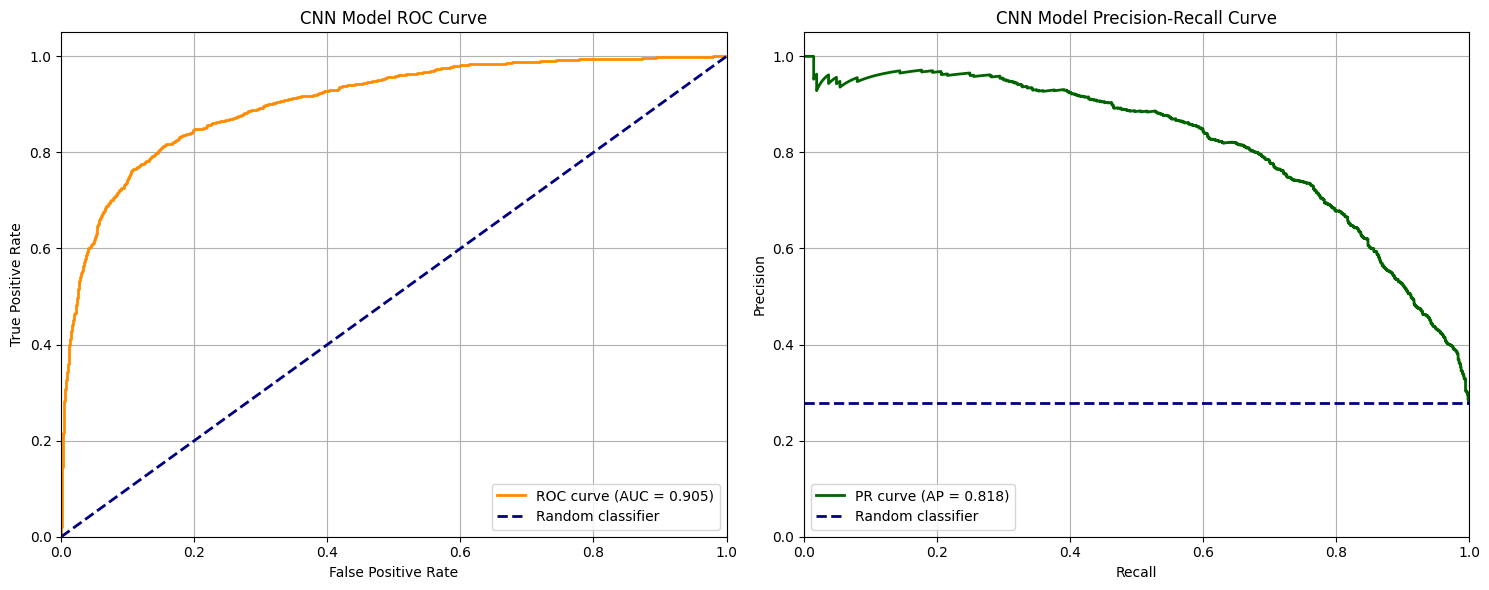

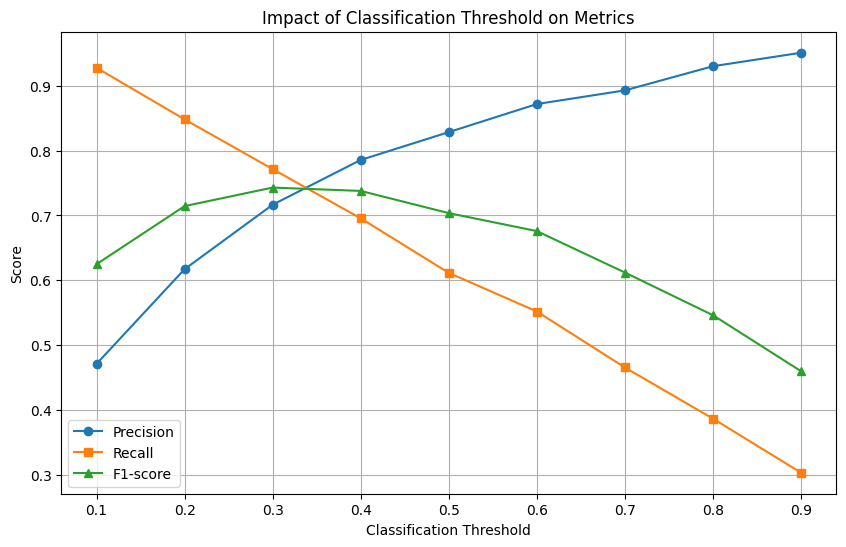


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9048

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8180

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.30
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.471, Recall=0.928, F1=0.625
   Threshold 0.2: Precision=0.617, Recall=0.848, F1=0.714
   Threshold 0.3: Precision=0.716, Recall=0.771, F1=0.743
   Threshold 0.4: Precision=0.786, Recall=0.695, F1=0.738
   Threshold 0.5: Precision=0.828, Recall=0.611, F1=0.704
   Threshold 0.6: Precision=0.872, Recall=0.552, F1=0.676
   Threshold 0.7: Precision=0.893, Recall=0.465, F1=0.612
   Threshold 0.8: Precision=0.930, Recall=0.386, F1=0.546
   Threshold 0.9: Precision=0.951, Recall=0.303, F1=0.460
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Cross-Validation Results:
Accuracy: 0.9058 ± 0.0030
Precision: 0.9382 ± 0.0096
Recall: 0.8823 ± 0.0060
F1: 0.9093 ± 0.0024

Test Set

In [50]:


def apply_mu_sigma_new(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Identify the minority and majority class based on class distribution
    class_labels, class_counts = np.unique(y, return_counts=True)
    minority_class = class_labels[np.argmin(class_counts)]
    majority_class = class_labels[np.argmax(class_counts)]

    # Split the original data into majority and minority class subsets
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]

    # Mu-Sigma augmentation on the minority class
    n_minority_samples = X_minority.shape[0]
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Initialize array for augmented minority data
    X_minority_augmented = np.zeros((n_minority_samples * 3, n_timesteps, n_features))

    for i in range(n_minority_samples):
        sample = X_minority[i]
        sigma = np.std(sample, axis=0, keepdims=True)  # Feature-wise standard deviation
        noise = np.random.normal(loc=0, scale=sigma, size=sample.shape)

        # Add original, +noise, and -noise versions to the augmented data
        X_minority_augmented[i] = sample
        X_minority_augmented[n_minority_samples + i] = sample + noise
        X_minority_augmented[2 * n_minority_samples + i] = sample - noise

    # Create labels for the augmented minority data
    y_minority_augmented = np.full(X_minority_augmented.shape[0], minority_class)

    # Combine the augmented minority class with the majority class
    X_augmented = np.vstack((X_majority, X_minority_augmented))
    y_augmented = np.concatenate((np.full(X_majority.shape[0], majority_class), y_minority_augmented))

    # Shuffle the combined dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented

cv_scores_ms2, test_scores_ms2, best_cnn_model_ms2, history_model_ms2, y_test_model2, y_test_pred_model2 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_mu_sigma_new, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after ADASYN: 26965 samples

==================== Training Set After apply_adasyn ====================
Dataset shape: (26965, 11, 9)
Labels shape: (26965,)

Class Distribution:
-----------------
Class 0: 14038 samples (52.06%)
Class 1: 12927 samples (47.94%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5142 - loss: 0.8395 - val_accuracy: 0.5948 - val_loss: 0.7914
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6086 - loss: 0.7865 - val_accuracy: 0.6299 - val_loss: 0.7612
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6399 - loss: 0.7536 - val_accuracy: 0.6531 - val_loss: 0.7348
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6688 - loss: 0.7151 - val_accuracy: 0.6755 - val_loss: 0.7016
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7004 - loss: 0.6891 - val_accuracy: 0.6892 - val_loss: 0.6797
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7053 - loss: 0.6710 - val_accuracy: 0.7007 - val_loss: 0.6591
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7264 - loss: 0.6420 - val_accuracy: 0.7367 - val_loss: 0.6378
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7359 - loss: 0.6218 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5191 - loss: 0.8347 - val_accuracy: 0.6162 - val_loss: 0.7980
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6107 - loss: 0.7824 - val_accuracy: 0.6351 - val_loss: 0.7624
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6399 - loss: 0.7531 - val_accuracy: 0.6807 - val_loss: 0.7488
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6679 - loss: 0.7283 - val_accuracy: 0.6831 - val_loss: 0.7158
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6824 - loss: 0.7007 - val_accuracy: 0.6970 - val_loss: 0.6827
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7105 - loss: 0.6707 - val_accuracy: 0.7204 - val_loss: 0.6536
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7253 - loss: 0.6472 - val_accuracy: 0.7196 - val_loss: 0.6378
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7294 - loss: 0.6282 - val_accuracy: 0.7230

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5226 - loss: 0.8347 - val_accuracy: 0.6115 - val_loss: 0.7845
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6023 - loss: 0.7880 - val_accuracy: 0.6375 - val_loss: 0.7613
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6447 - loss: 0.7558 - val_accuracy: 0.6694 - val_loss: 0.7264
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6687 - loss: 0.7329 - val_accuracy: 0.6805 - val_loss: 0.7014
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6844 - loss: 0.7058 - val_accuracy: 0.6939 - val_loss: 0.6677
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7064 - loss: 0.6748 - val_accuracy: 0.7176 - val_loss: 0.6487
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7274 - loss: 0.6394 - val_accuracy: 0.7610 - val_loss: 0.6136
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7445 - loss: 0.6159 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5189 - loss: 0.8376 - val_accuracy: 0.5717 - val_loss: 0.7910
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6018 - loss: 0.7876 - val_accuracy: 0.6534 - val_loss: 0.7630
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6404 - loss: 0.7538 - val_accuracy: 0.6711 - val_loss: 0.7263
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6638 - loss: 0.7269 - val_accuracy: 0.7080 - val_loss: 0.6974
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6956 - loss: 0.6900 - val_accuracy: 0.7195 - val_loss: 0.6585
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7099 - loss: 0.6705 - val_accuracy: 0.7215 - val_loss: 0.6386
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7329 - loss: 0.6338 - val_accuracy: 0.7517 - val_loss: 0.6135
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7404 - loss: 0.6201 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5062 - loss: 0.8389 - val_accuracy: 0.5624 - val_loss: 0.7982
Epoch 2/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5989 - loss: 0.7905 - val_accuracy: 0.6356 - val_loss: 0.7638
Epoch 3/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6351 - loss: 0.7538 - val_accuracy: 0.6497 - val_loss: 0.7300
Epoch 4/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6670 - loss: 0.7223 - val_accuracy: 0.6970 - val_loss: 0.7070
Epoch 5/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6858 - loss: 0.6970 - val_accuracy: 0.7061 - val_loss: 0.6703
Epoch 6/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7169 - loss: 0.6620 - val_accuracy: 0.6902 - val_loss: 0.6578
Epoch 7/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7263 - loss: 0.6402 - val_accuracy: 0.7248 - val_loss: 0.6294
Epoch 8/100
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7454 - loss: 0.6191 - val_accuracy: 0.7502

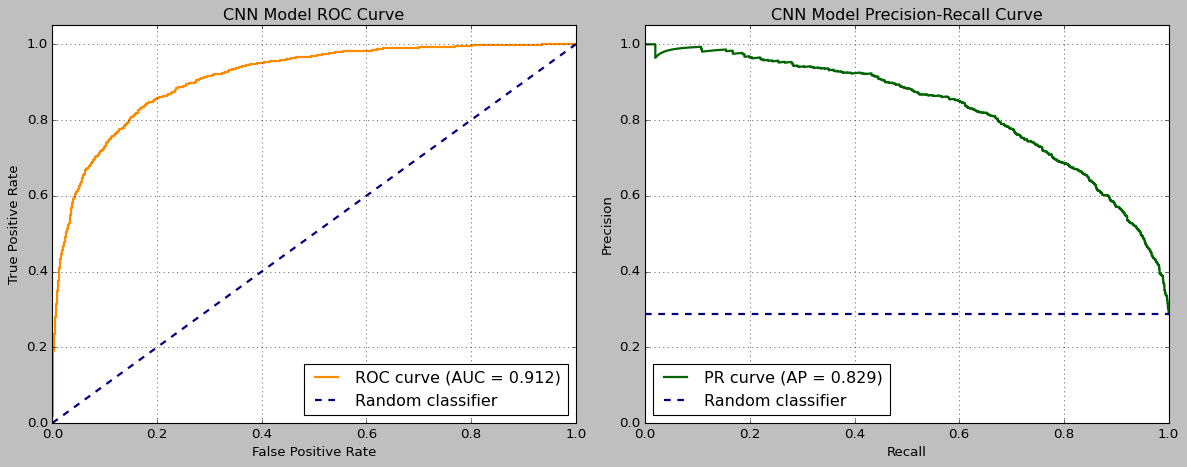

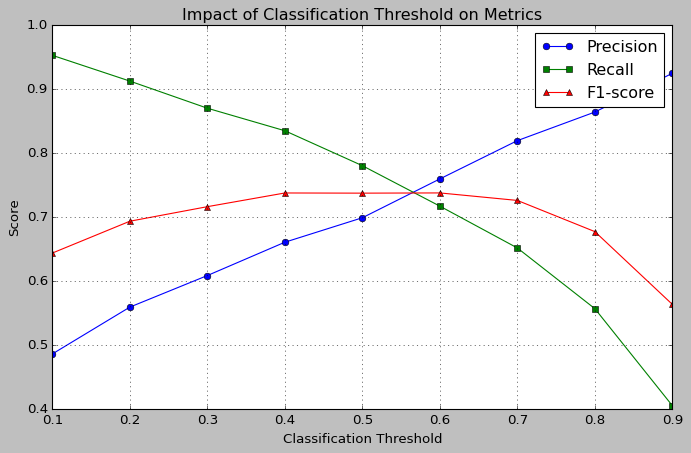


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9115

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8290

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.486, Recall=0.953, F1=0.644
   Threshold 0.2: Precision=0.559, Recall=0.912, F1=0.693
   Threshold 0.3: Precision=0.609, Recall=0.870, F1=0.716
   Threshold 0.4: Precision=0.661, Recall=0.835, F1=0.738
   Threshold 0.5: Precision=0.699, Recall=0.780, F1=0.737
   Threshold 0.6: Precision=0.760, Recall=0.717, F1=0.738
   Threshold 0.7: Precision=0.819, Recall=0.652, F1=0.726
   Threshold 0.8: Precision=0.864, Recall=0.557, F1=0.677
   Threshold 0.9: Precision=0.925, Recall=0.405, F1=0.563
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Cross-Validation Results:
Accuracy: 0.8933 ± 0.0061
Precision: 0.8573 ± 0.0108
Recall: 0.9329 ± 0.0070
F1: 0.8934 ± 0.0054

Test Set

In [8]:

## final_df_ambient
# just adasyn
cv_scores_1, test_scores_1, best_cnn_model_1, history_model_1 = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_adasyn, 
    window_size=11, step_size=1
)

using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Data after ROS: 27978 samples

==================== Training Set After apply_ros ====================
current n_window size 27978
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5506 - loss: 0.8131 - val_accuracy: 0.6142 - val_loss: 0.7695
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6367 - loss: 0.7607 - val_accuracy: 0.6632 - val_loss: 0.7297
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6625 - loss: 0.7323 - val_accuracy: 0.6744 - val_loss: 0.7135
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6758 - loss: 0.7162 - val_accuracy: 0.6785 - val_loss: 0.6888
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6887 - loss: 0.6969 - val_accuracy: 0.7046 - val_loss: 0.6609
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7026 - loss: 0.6710 - val_accuracy: 0.6878 - val_loss: 0.6607
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7183 - loss: 0.6517 - val_accuracy: 0.7273 - val_loss: 0.6284
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7294 - loss: 0.6309 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5389 - loss: 0.8204 - val_accuracy: 0.6174 - val_loss: 0.7722
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6343 - loss: 0.7595 - val_accuracy: 0.6651 - val_loss: 0.7516
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6607 - loss: 0.7332 - val_accuracy: 0.6878 - val_loss: 0.7215
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6776 - loss: 0.7123 - val_accuracy: 0.6801 - val_loss: 0.6948
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6940 - loss: 0.6904 - val_accuracy: 0.7178 - val_loss: 0.6786
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7118 - loss: 0.6628 - val_accuracy: 0.7041 - val_loss: 0.6612
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7231 - loss: 0.6397 - val_accuracy: 0.7366 - val_loss: 0.6260
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7357 - loss: 0.6205 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5473 - loss: 0.8172 - val_accuracy: 0.6310 - val_loss: 0.7744
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6283 - loss: 0.7705 - val_accuracy: 0.6687 - val_loss: 0.7437
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6552 - loss: 0.7404 - val_accuracy: 0.6739 - val_loss: 0.7203
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6707 - loss: 0.7175 - val_accuracy: 0.7021 - val_loss: 0.7023
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6897 - loss: 0.6973 - val_accuracy: 0.6892 - val_loss: 0.6828
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7023 - loss: 0.6757 - val_accuracy: 0.7257 - val_loss: 0.6534
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7152 - loss: 0.6527 - val_accuracy: 0.7452 - val_loss: 0.6409
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7356 - loss: 0.6256 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5447 - loss: 0.8184 - val_accuracy: 0.6431 - val_loss: 0.7783
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6294 - loss: 0.7679 - val_accuracy: 0.6413 - val_loss: 0.7424
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6610 - loss: 0.7338 - val_accuracy: 0.6919 - val_loss: 0.7111
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6794 - loss: 0.7164 - val_accuracy: 0.7056 - val_loss: 0.6937
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6975 - loss: 0.6875 - val_accuracy: 0.7181 - val_loss: 0.6675
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7075 - loss: 0.6660 - val_accuracy: 0.7237 - val_loss: 0.6431
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7214 - loss: 0.6422 - val_accuracy: 0.7269 - val_loss: 0.6324
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7382 - loss: 0.6198 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5333 - loss: 0.8213 - val_accuracy: 0.6204 - val_loss: 0.7763
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.6279 - loss: 0.7659 - val_accuracy: 0.6293 - val_loss: 0.7500
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6522 - loss: 0.7412 - val_accuracy: 0.6718 - val_loss: 0.7316
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6748 - loss: 0.7139 - val_accuracy: 0.6772 - val_loss: 0.7078
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.6952 - loss: 0.6861 - val_accuracy: 0.6953 - val_loss: 0.6947
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7044 - loss: 0.6673 - val_accuracy: 0.7083 - val_loss: 0.6684
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7157 - loss: 0.6526 - val_accuracy: 0.7047 - val_loss: 0.6526
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7342 - loss: 0.6268

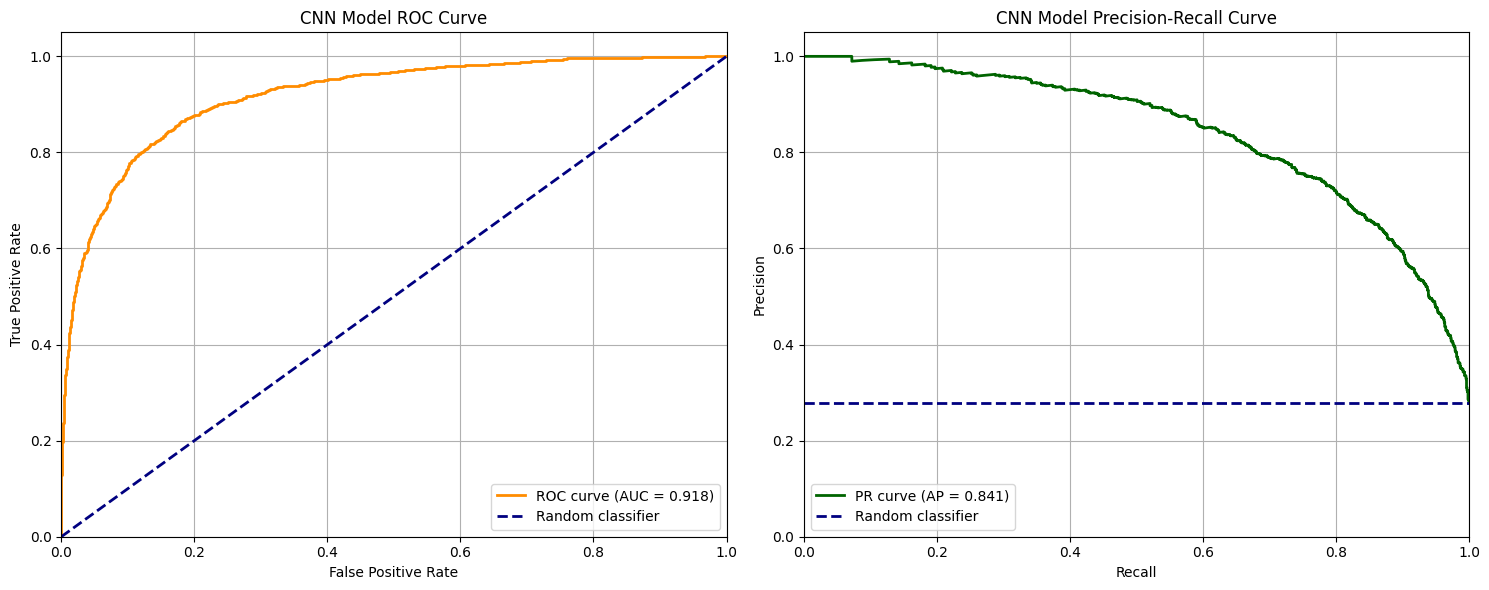

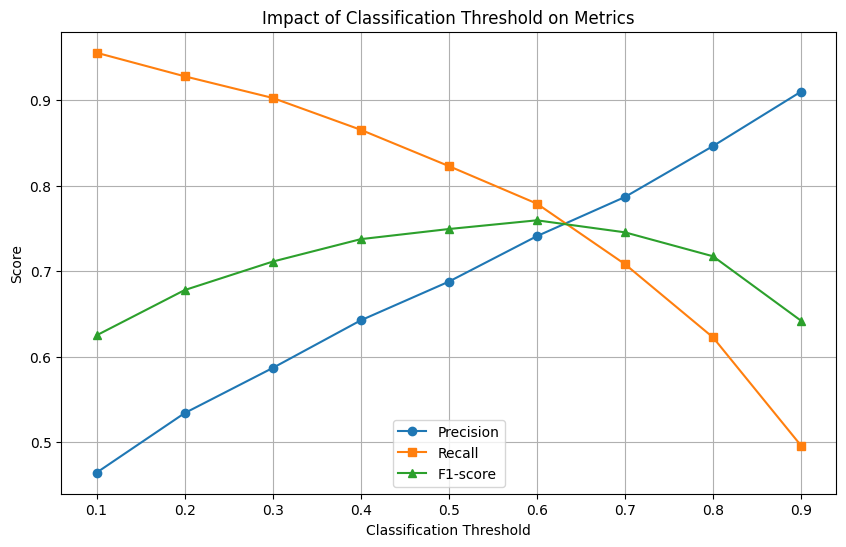


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9181

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8409

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.464, Recall=0.955, F1=0.625
   Threshold 0.2: Precision=0.534, Recall=0.928, F1=0.678
   Threshold 0.3: Precision=0.587, Recall=0.902, F1=0.711
   Threshold 0.4: Precision=0.642, Recall=0.865, F1=0.737
   Threshold 0.5: Precision=0.688, Recall=0.823, F1=0.749
   Threshold 0.6: Precision=0.741, Recall=0.779, F1=0.759
   Threshold 0.7: Precision=0.787, Recall=0.708, F1=0.745
   Threshold 0.8: Precision=0.846, Recall=0.622, F1=0.717
   Threshold 0.9: Precision=0.910, Recall=0.496, F1=0.642
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Cross-Validation Results:
Accuracy: 0.9070 ± 0.0024
Precision: 0.8683 ± 0.0075
Recall: 0.9598 ± 0.0084
F1: 0.9117 ± 0.0020

Test Set

In [51]:
from imblearn.over_sampling import RandomOverSampler

# just ros
# cv_scores_1e, test_scores_1e, best_cnn_model_1e, history_model_1e = kfold_model_performance(
#     final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_ros, 
#     window_size=11, step_size=1
# )
# updated code 
cv_scores_r, test_scores_r, best_cnn_model_r, history_model_r, y_test_modelr, y_test_pred_modelr = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_ros, 
    window_size=11, step_size=1
)
# no imb classificiaotn report

# NO sampling

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training set: NO Sampling ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

Fold 1/5
Epoch 1/100


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7164 - loss: 0.7416 - val_accuracy: 0.7084 - val_loss: 0.7004
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7197 - loss: 0.6919 - val_accuracy: 0.7180 - val_loss: 0.6945
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7204 - loss: 0.6783 - val_accuracy: 0.7309 - val_loss: 0.6844
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7250 - loss: 0.6735 - val_accuracy: 0.7203 - val_loss: 0.6740
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7344 - loss: 0.6607 - val_accuracy: 0.7330 - val_loss: 0.6586
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7468 - loss: 0.6446 - val_accuracy: 0.7407 - val_loss: 0.6509
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7455 - loss: 0.6338 - val_accuracy: 0.7528 - val_loss: 0.6402
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7529 - loss: 0.6233 - val_accuracy: 0.7544

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.6937 - loss: 0.7506 - val_accuracy: 0.7257 - val_loss: 0.7006
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7097 - loss: 0.7008 - val_accuracy: 0.7273 - val_loss: 0.6793
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7239 - loss: 0.6770 - val_accuracy: 0.7157 - val_loss: 0.6699
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7305 - loss: 0.6607 - val_accuracy: 0.7330 - val_loss: 0.6641
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7405 - loss: 0.6503 - val_accuracy: 0.7490 - val_loss: 0.6563
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7524 - loss: 0.6314 - val_accuracy: 0.7412 - val_loss: 0.6406
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7536 - loss: 0.6289 - val_accuracy: 0.7508 - val_loss: 0.6392
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7548 - loss: 0.6225 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7061 - loss: 0.7493 - val_accuracy: 0.7242 - val_loss: 0.7050
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7178 - loss: 0.6961 - val_accuracy: 0.7345 - val_loss: 0.6899
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7255 - loss: 0.6856 - val_accuracy: 0.7466 - val_loss: 0.6756
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7410 - loss: 0.6588 - val_accuracy: 0.7371 - val_loss: 0.6647
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7391 - loss: 0.6521 - val_accuracy: 0.7353 - val_loss: 0.6529
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7457 - loss: 0.6366 - val_accuracy: 0.7497 - val_loss: 0.6516
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7472 - loss: 0.6345 - val_accuracy: 0.7608 - val_loss: 0.6431
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7515 - loss: 0.6287 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7102 - loss: 0.7502 - val_accuracy: 0.7182 - val_loss: 0.7100
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7040 - loss: 0.7064 - val_accuracy: 0.7257 - val_loss: 0.6884
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7247 - loss: 0.6753 - val_accuracy: 0.7296 - val_loss: 0.6764
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7387 - loss: 0.6633 - val_accuracy: 0.7448 - val_loss: 0.6690
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7391 - loss: 0.6481 - val_accuracy: 0.7430 - val_loss: 0.6563
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7393 - loss: 0.6433 - val_accuracy: 0.7580 - val_loss: 0.6438
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7427 - loss: 0.6356 - val_accuracy: 0.7518 - val_loss: 0.6373
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7556 - loss: 0.6146 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7068 - loss: 0.7486 - val_accuracy: 0.7198 - val_loss: 0.7031
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7111 - loss: 0.7008 - val_accuracy: 0.7373 - val_loss: 0.6835
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7233 - loss: 0.6784 - val_accuracy: 0.7361 - val_loss: 0.6791
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7307 - loss: 0.6697 - val_accuracy: 0.7319 - val_loss: 0.6673
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7361 - loss: 0.6578 - val_accuracy: 0.7423 - val_loss: 0.6672
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7406 - loss: 0.6500 - val_accuracy: 0.7503 - val_loss: 0.6504
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7537 - loss: 0.6313 - val_accuracy: 0.7508 - val_loss: 0.6365
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7544 - loss: 0.6246 - val_acc

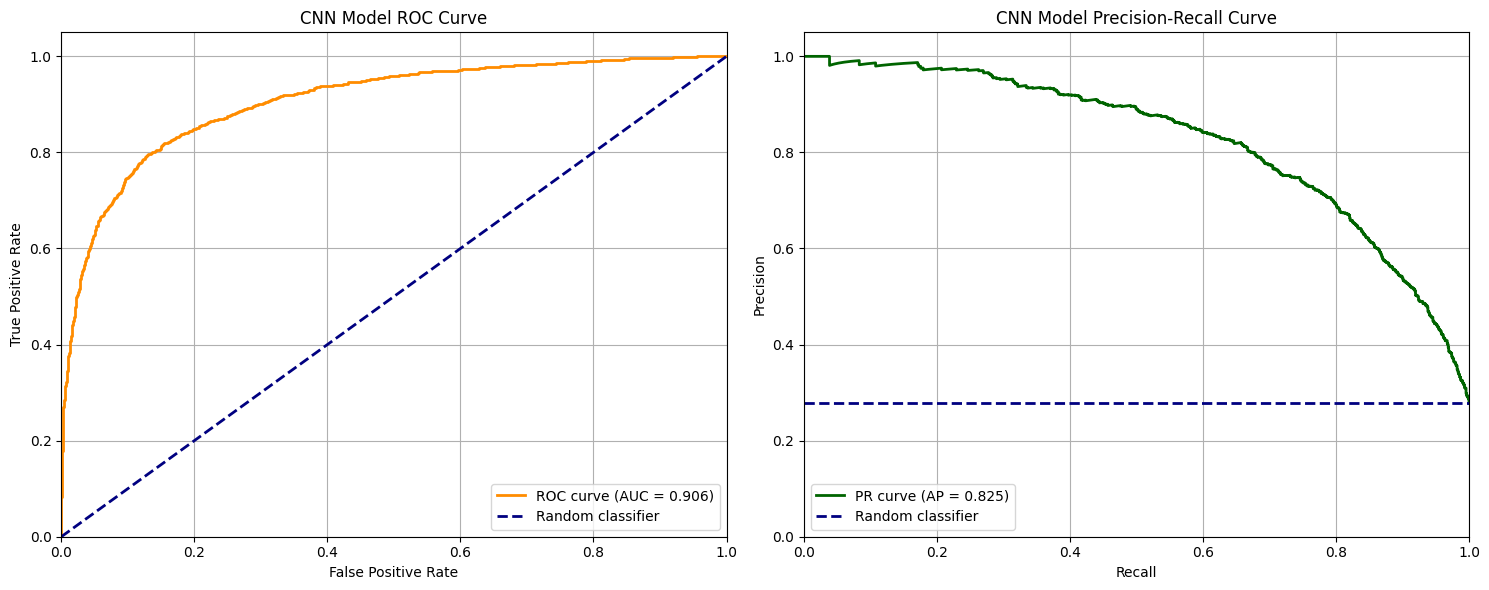

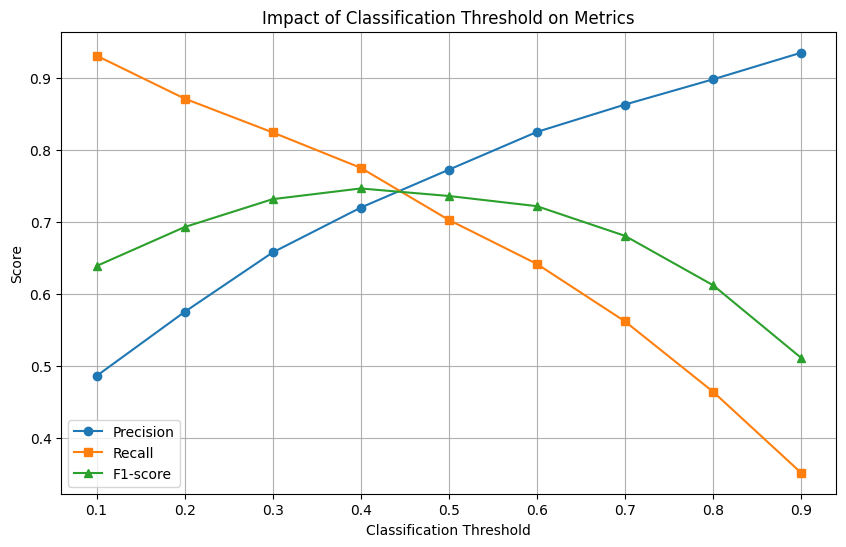


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9058

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8250

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.486, Recall=0.931, F1=0.639
   Threshold 0.2: Precision=0.575, Recall=0.871, F1=0.693
   Threshold 0.3: Precision=0.658, Recall=0.824, F1=0.732
   Threshold 0.4: Precision=0.720, Recall=0.775, F1=0.747
   Threshold 0.5: Precision=0.773, Recall=0.703, F1=0.736
   Threshold 0.6: Precision=0.825, Recall=0.642, F1=0.722
   Threshold 0.7: Precision=0.863, Recall=0.562, F1=0.681
   Threshold 0.8: Precision=0.898, Recall=0.465, F1=0.612
   Threshold 0.9: Precision=0.935, Recall=0.352, F1=0.512
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Cross-Validation Results:
Accuracy: 0.8595 ± 0.0089
Precision: 0.7835 ± 0.0231
Recall: 0.6837 ± 0.0426
F1: 0.7291 ± 0.0226

Test Set

In [11]:
# with ambient feature 
cv_scores_1d, test_scores_1d, best_cnn_model_1d, history_model_1d = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=None, 
    window_size=11, step_size=1
)


Training set shape: (19360, 11, 8), Test set shape: (4841, 11, 8)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 8)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)

==================== Training set: NO Sampling ====================
Dataset shape: (19360, 11, 8)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7012 - loss: 0.7472 - val_accuracy: 0.7084 - val_loss: 0.7064
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7204 - loss: 0.6918 - val_accuracy: 0.7120 - val_loss: 0.6912
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7238 - loss: 0.6794 - val_accuracy: 0.6880 - val_loss: 0.6914
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7363 - loss: 0.6631 - val_accuracy: 0.7373 - val_loss: 0.6766
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7448 - loss: 0.6501 - val_accuracy: 0.7384 - val_loss: 0.6666
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7503 - loss: 0.6308 - val_accuracy: 0.7350 - val_loss: 0.6570
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7576 - loss: 0.6315 - val_accuracy: 0.7376 - val_loss: 0.6500
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7549 - loss: 0.6191 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7071 - loss: 0.7459 - val_accuracy: 0.7133 - val_loss: 0.7032
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7131 - loss: 0.6947 - val_accuracy: 0.7009 - val_loss: 0.7042
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7206 - loss: 0.6816 - val_accuracy: 0.7392 - val_loss: 0.6808
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7315 - loss: 0.6653 - val_accuracy: 0.7141 - val_loss: 0.6694
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7331 - loss: 0.6556 - val_accuracy: 0.7381 - val_loss: 0.6617
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7540 - loss: 0.6364 - val_accuracy: 0.7342 - val_loss: 0.6536
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7517 - loss: 0.6361 - val_accuracy: 0.7265 - val_loss: 0.6469
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7555 - loss: 0.6187 - val_accuracy: 0.7185

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7082 - loss: 0.7477 - val_accuracy: 0.7092 - val_loss: 0.7097
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7183 - loss: 0.7007 - val_accuracy: 0.7164 - val_loss: 0.6954
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7209 - loss: 0.6850 - val_accuracy: 0.7275 - val_loss: 0.6767
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7248 - loss: 0.6742 - val_accuracy: 0.7451 - val_loss: 0.6602
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7366 - loss: 0.6555 - val_accuracy: 0.7526 - val_loss: 0.6585
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7438 - loss: 0.6488 - val_accuracy: 0.7454 - val_loss: 0.6418
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7517 - loss: 0.6362 - val_accuracy: 0.7304 - val_loss: 0.6484
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7508 - loss: 0.6222 - val_accuracy: 0.7518

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6995 - loss: 0.7477 - val_accuracy: 0.7286 - val_loss: 0.6972
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7094 - loss: 0.7100 - val_accuracy: 0.7340 - val_loss: 0.6869
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7196 - loss: 0.6849 - val_accuracy: 0.7423 - val_loss: 0.6728
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7270 - loss: 0.6741 - val_accuracy: 0.7402 - val_loss: 0.6618
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7384 - loss: 0.6619 - val_accuracy: 0.7454 - val_loss: 0.6553
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7392 - loss: 0.6511 - val_accuracy: 0.7523 - val_loss: 0.6499
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7515 - loss: 0.6334 - val_accuracy: 0.7686 - val_loss: 0.6406
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7557 - loss: 0.6254 - val_accuracy: 0.7590

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7039 - loss: 0.7476 - val_accuracy: 0.7089 - val_loss: 0.7043
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7138 - loss: 0.7048 - val_accuracy: 0.7410 - val_loss: 0.6851
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7185 - loss: 0.6864 - val_accuracy: 0.7082 - val_loss: 0.6785
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7319 - loss: 0.6703 - val_accuracy: 0.7492 - val_loss: 0.6639
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7452 - loss: 0.6553 - val_accuracy: 0.7510 - val_loss: 0.6514
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7465 - loss: 0.6389 - val_accuracy: 0.7585 - val_loss: 0.6436
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7545 - loss: 0.6270 - val_accuracy: 0.7268 - val_loss: 0.6465
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7518 - loss: 0.6311 - val_accuracy: 0.7539

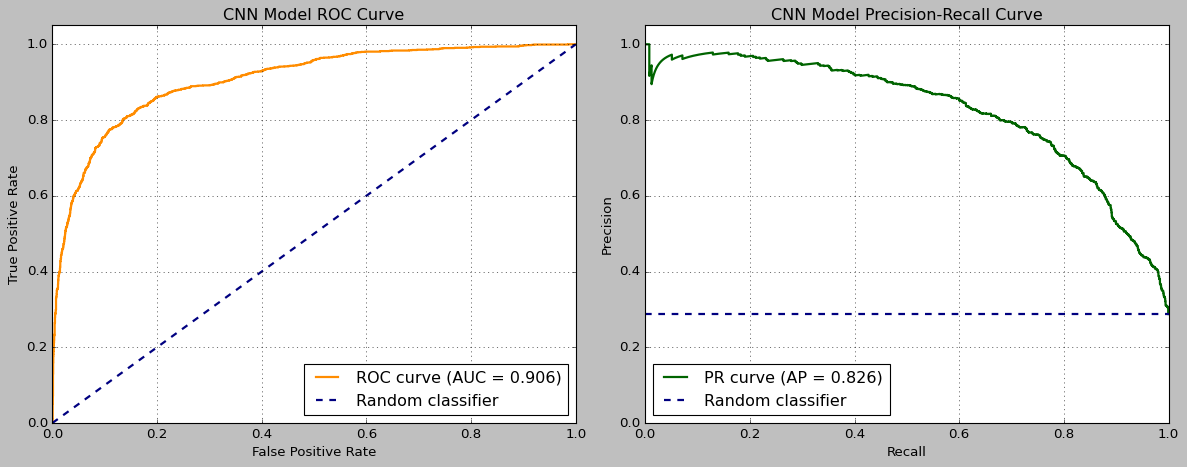

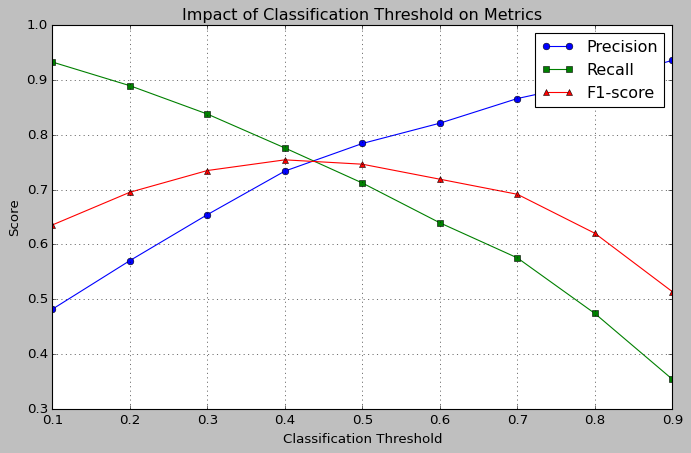


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9063

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8264

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.482, Recall=0.932, F1=0.635
   Threshold 0.2: Precision=0.571, Recall=0.889, F1=0.695
   Threshold 0.3: Precision=0.654, Recall=0.838, F1=0.735
   Threshold 0.4: Precision=0.734, Recall=0.776, F1=0.754
   Threshold 0.5: Precision=0.784, Recall=0.712, F1=0.746
   Threshold 0.6: Precision=0.821, Recall=0.639, F1=0.719
   Threshold 0.7: Precision=0.866, Recall=0.575, F1=0.691
   Threshold 0.8: Precision=0.897, Recall=0.474, F1=0.620
   Threshold 0.9: Precision=0.935, Recall=0.354, F1=0.514
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Cross-Validation Results:
Accuracy: 0.8531 ± 0.0074
Precision: 0.7749 ± 0.0166
Recall: 0.6569 ± 0.0323
F1: 0.7105 ± 0.0188

Test Set

In [24]:
# without ambient feature 
cv_scores_1d, test_scores_1d, best_cnn_model_1d, history_model_1d = kfold_model_performance(
    final_df_clean, build_model_fn=build_1d_cnn, augmentation_fn=None,
    window_size=11, step_size=1
)

## Oversampling - mu-sigma

using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After apply_mu_sigma_new ====================
current n_window size 30102
Dataset shape: (30102, 11, 9)
Labels shape: (30102,)

Class Distribution:
-----------------
Class 0: 13989 samples (46.47%)
Class 1: 16113 samples (53.53%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6871 - loss: 0.6082 - val_accuracy: 0.8284 - val_loss: 0.4530
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8213 - loss: 0.4531 - val_accuracy: 0.8361 - val_loss: 0.4498
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8280 - loss: 0.4442 - val_accuracy: 0.8384 - val_loss: 0.4351
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8389 - loss: 0.4216 - val_accuracy: 0.8411 - val_loss: 0.4284
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8402 - loss: 0.4135 - val_accuracy: 0.8366 - val_loss: 0.4249
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8418 - loss: 0.4157 - val_accuracy: 0.8444 - val_loss: 0.4166
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8463 - loss: 0.4053 - val_accuracy: 0.8480 - val_loss: 0.4114
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8481 - loss: 0.4018 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6965 - loss: 0.6037 - val_accuracy: 0.8306 - val_loss: 0.4540
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8181 - loss: 0.4529 - val_accuracy: 0.8326 - val_loss: 0.4400
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8295 - loss: 0.4360 - val_accuracy: 0.8296 - val_loss: 0.4527
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8251 - loss: 0.4376 - val_accuracy: 0.8333 - val_loss: 0.4399
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8364 - loss: 0.4232 - val_accuracy: 0.8354 - val_loss: 0.4250
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8401 - loss: 0.4165 - val_accuracy: 0.8376 - val_loss: 0.4150
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8459 - loss: 0.4005 - val_accuracy: 0.8442 - val_loss: 0.4123
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8469 - loss: 0.3986 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6939 - loss: 0.6010 - val_accuracy: 0.8209 - val_loss: 0.4515
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8153 - loss: 0.4630 - val_accuracy: 0.8355 - val_loss: 0.4439
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8256 - loss: 0.4450 - val_accuracy: 0.8297 - val_loss: 0.4289
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8332 - loss: 0.4333 - val_accuracy: 0.8455 - val_loss: 0.4245
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8416 - loss: 0.4200 - val_accuracy: 0.8460 - val_loss: 0.4234
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8423 - loss: 0.4118 - val_accuracy: 0.8455 - val_loss: 0.4047
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8456 - loss: 0.4034 - val_accuracy: 0.8520 - val_loss: 0.3987
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8502 - loss: 0.3908 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6961 - loss: 0.6026 - val_accuracy: 0.8216 - val_loss: 0.4713
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8195 - loss: 0.4549 - val_accuracy: 0.8184 - val_loss: 0.4592
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8329 - loss: 0.4330 - val_accuracy: 0.8236 - val_loss: 0.4505
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8379 - loss: 0.4237 - val_accuracy: 0.8289 - val_loss: 0.4385
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8396 - loss: 0.4204 - val_accuracy: 0.8307 - val_loss: 0.4330
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8435 - loss: 0.4051 - val_accuracy: 0.8367 - val_loss: 0.4289
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8461 - loss: 0.3995 - val_accuracy: 0.8367 - val_loss: 0.4187
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8568 - loss: 0.3847 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6947 - loss: 0.6060 - val_accuracy: 0.8257 - val_loss: 0.4558
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8149 - loss: 0.4629 - val_accuracy: 0.8284 - val_loss: 0.4406
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8269 - loss: 0.4399 - val_accuracy: 0.8311 - val_loss: 0.4314
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8334 - loss: 0.4303 - val_accuracy: 0.8367 - val_loss: 0.4292
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8348 - loss: 0.4232 - val_accuracy: 0.8453 - val_loss: 0.4204
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8482 - loss: 0.4064 - val_accuracy: 0.8455 - val_loss: 0.4214
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8436 - loss: 0.4062 - val_accuracy: 0.8440 - val_loss: 0.4020
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8512 - loss: 0.3946 - val_accu

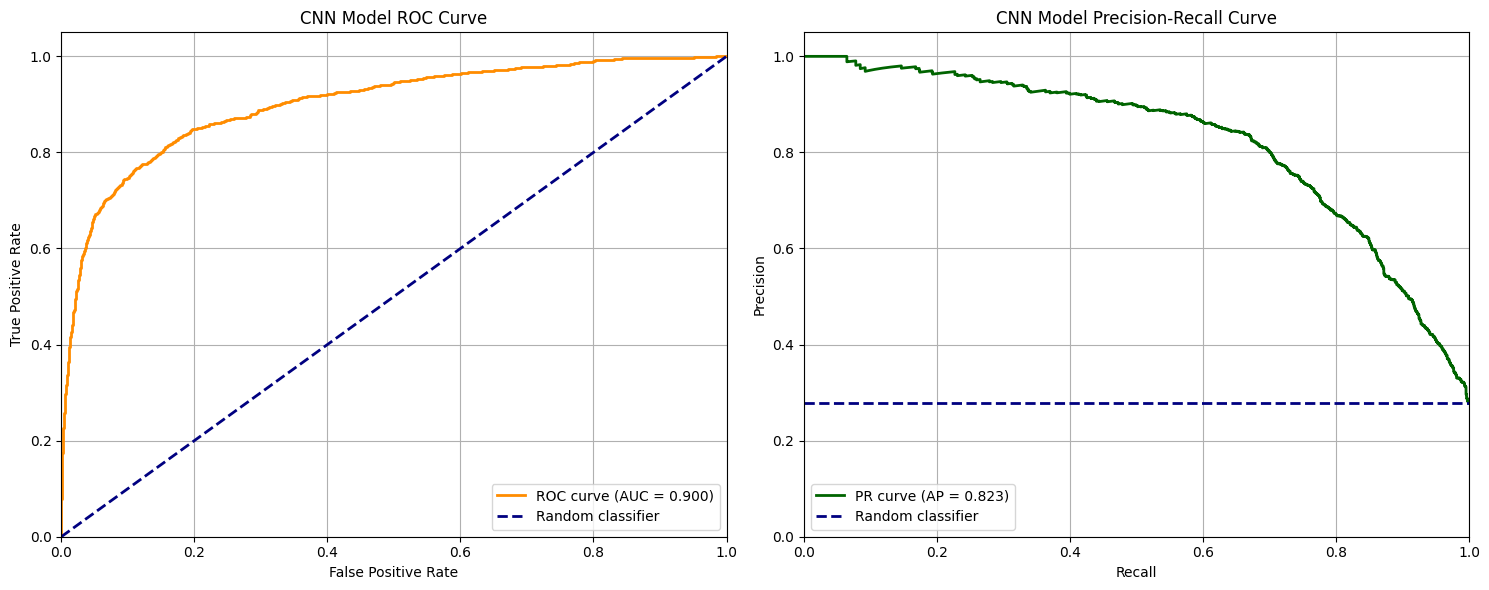

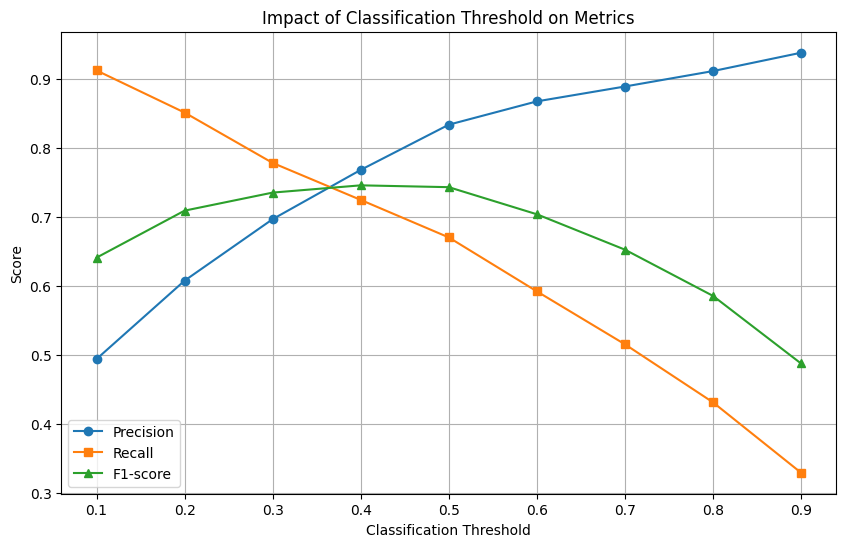


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9004

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8233

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.495, Recall=0.913, F1=0.642
   Threshold 0.2: Precision=0.608, Recall=0.852, F1=0.710
   Threshold 0.3: Precision=0.697, Recall=0.779, F1=0.736
   Threshold 0.4: Precision=0.769, Recall=0.725, F1=0.746
   Threshold 0.5: Precision=0.834, Recall=0.671, F1=0.744
   Threshold 0.6: Precision=0.868, Recall=0.593, F1=0.704
   Threshold 0.7: Precision=0.890, Recall=0.516, F1=0.653
   Threshold 0.8: Precision=0.912, Recall=0.432, F1=0.586
   Threshold 0.9: Precision=0.939, Recall=0.330, F1=0.488
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


ValueError: Found array with dim 3. TSNE expected <= 2.

In [17]:
# mu sigma augmentaitno only 
from sklearn.manifold import TSNE

def apply_mu_sigma_new(X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Balances the dataset using Mu-Sigma augmentation by selectively augmenting the minority class.
    This function returns a balanced dataset in the format (X_augmented, y_augmented).
    
    Args:
        X (np.ndarray): Original dataset (n_samples, n_timesteps, n_features).
        y (np.ndarray): Corresponding labels (n_samples,).

    Returns:
        Tuple[np.ndarray, np.ndarray]: Balanced and shuffled dataset.
    """
    # Identify the minority and majority class based on class distribution
    class_labels, class_counts = np.unique(y, return_counts=True)
    minority_class = class_labels[np.argmin(class_counts)]
    majority_class = class_labels[np.argmax(class_counts)]

    # Split the original data into majority and minority class subsets
    X_majority = X[y == majority_class]
    X_minority = X[y == minority_class]

    # Mu-Sigma augmentation on the minority class
    n_minority_samples = X_minority.shape[0]
    n_timesteps, n_features = X.shape[1], X.shape[2]

    # Initialize array for augmented minority data
    X_minority_augmented = np.zeros((n_minority_samples * 3, n_timesteps, n_features))

    for i in range(n_minority_samples):
        sample = X_minority[i]
        sigma = np.std(sample, axis=0, keepdims=True)  # Feature-wise standard deviation
        noise = np.random.normal(loc=0, scale=sigma, size=sample.shape)

        # Add original, +noise, and -noise versions to the augmented data
        X_minority_augmented[i] = sample
        X_minority_augmented[n_minority_samples + i] = sample + noise
        X_minority_augmented[2 * n_minority_samples + i] = sample - noise

    # Create labels for the augmented minority data
    y_minority_augmented = np.full(X_minority_augmented.shape[0], minority_class)

    # Combine the augmented minority class with the majority class
    X_augmented = np.vstack((X_majority, X_minority_augmented))
    y_augmented = np.concatenate((np.full(X_majority.shape[0], majority_class), y_minority_augmented))

    # Shuffle the combined dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]

    return X_augmented, y_augmented

cv_scores_2dm, test_scores_2dm, best_cnn_model_2dm, history_model_2dm = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=apply_mu_sigma_new, 
    window_size=11, step_size=1, visualise=True
)


In [ ]:
# none 
cv_scores_none, test_scores_none, best_cnn_model_none, history_model_none = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=None, 
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 14038 samples (72.51%)
Class 1: 5322 samples (27.49%)
Data after SMOTE: 28076 samples

==================== Training Set After apply_mu_sigma ====================
Dataset shape: (84228, 11, 9)
Labels shape: (84228,)

Class Distribution:
-----------------
Class 0: 42114 samples (50.00%)
Class 1: 42114 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5287 - loss: 0.8308 - val_accuracy: 0.5367 - val_loss: 0.8027
Epoch 2/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5857 - loss: 0.7965 - val_accuracy: 0.5868 - val_loss: 0.7822
Epoch 3/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6087 - loss: 0.7806 - val_accuracy: 0.5941 - val_loss: 0.7767
Epoch 4/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6187 - loss: 0.7696 - val_accuracy: 0.5934 - val_loss: 0.7682
Epoch 5/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6240 - loss: 0.7616 - val_accuracy: 0.6217 - val_loss: 0.7643
Epoch 6/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6347 - loss: 0.7535 - val_accuracy: 0.6166 - val_loss: 0.7548
Epoch 7/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6376 - loss: 0.7463 - val_accuracy: 0.6172 - val_loss: 0.7512
Epoch 8/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6440 - loss: 0

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5305 - loss: 0.8289 - val_accuracy: 0.5573 - val_loss: 0.7995
Epoch 2/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5816 - loss: 0.7971 - val_accuracy: 0.5720 - val_loss: 0.7855
Epoch 3/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6051 - loss: 0.7784 - val_accuracy: 0.6067 - val_loss: 0.7740
Epoch 4/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6170 - loss: 0.7713 - val_accuracy: 0.6337 - val_loss: 0.7688
Epoch 5/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6245 - loss: 0.7631 - val_accuracy: 0.6134 - val_loss: 0.7623
Epoch 6/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6379 - loss: 0.7494 - val_accuracy: 0.6315 - val_loss: 0.7588
Epoch 7/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6420 - loss: 0.7456 - val_accuracy: 0.6329 - val_loss: 0.7529
Epoch 8/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6495 - loss: 0.7360 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5239 - loss: 0.8344 - val_accuracy: 0.5563 - val_loss: 0.8016
Epoch 2/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5788 - loss: 0.8003 - val_accuracy: 0.5851 - val_loss: 0.7886
Epoch 3/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5997 - loss: 0.7849 - val_accuracy: 0.6096 - val_loss: 0.7774
Epoch 4/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6159 - loss: 0.7723 - val_accuracy: 0.5946 - val_loss: 0.7726
Epoch 5/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6274 - loss: 0.7623 - val_accuracy: 0.5998 - val_loss: 0.7671
Epoch 6/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6333 - loss: 0.7546 - val_accuracy: 0.6224 - val_loss: 0.7583
Epoch 7/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6412 - loss: 0.7450 - val_accuracy: 0.6415 - val_loss: 0.7561
Epoch 8/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6472 - loss: 0.7407 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5282 - loss: 0.8308 - val_accuracy: 0.5849 - val_loss: 0.7981
Epoch 2/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5883 - loss: 0.7978 - val_accuracy: 0.5877 - val_loss: 0.7843
Epoch 3/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6074 - loss: 0.7773 - val_accuracy: 0.5918 - val_loss: 0.7749
Epoch 4/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6184 - loss: 0.7696 - val_accuracy: 0.6153 - val_loss: 0.7621
Epoch 5/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6313 - loss: 0.7561 - val_accuracy: 0.6050 - val_loss: 0.7618
Epoch 6/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6351 - loss: 0.7509 - val_accuracy: 0.6207 - val_loss: 0.7531
Epoch 7/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6384 - loss: 0.7467 - val_accuracy: 0.6177 - val_loss: 0.7516
Epoch 8/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6461 - loss: 0.7400 - val_

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5357 - loss: 0.8278 - val_accuracy: 0.5538 - val_loss: 0.8003
Epoch 2/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5818 - loss: 0.7986 - val_accuracy: 0.5948 - val_loss: 0.7807
Epoch 3/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6085 - loss: 0.7796 - val_accuracy: 0.6021 - val_loss: 0.7714
Epoch 4/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6217 - loss: 0.7683 - val_accuracy: 0.6372 - val_loss: 0.7674
Epoch 5/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6263 - loss: 0.7604 - val_accuracy: 0.6047 - val_loss: 0.7575
Epoch 6/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6364 - loss: 0.7501 - val_accuracy: 0.6129 - val_loss: 0.7548
Epoch 7/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6431 - loss: 0.7439 - val_accuracy: 0.6408 - val_loss: 0.7454
Epoch 8/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6517 - loss: 0.7398 - val_

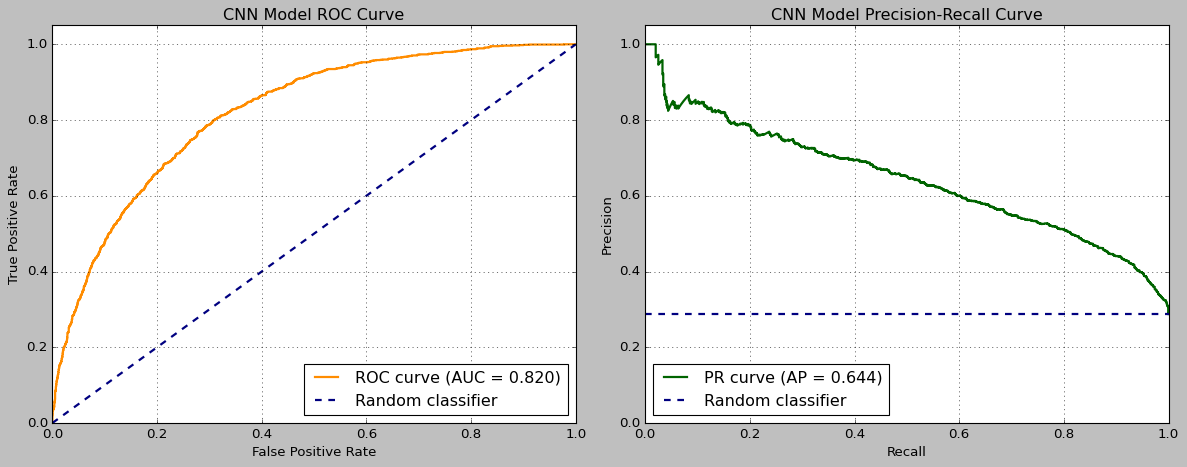

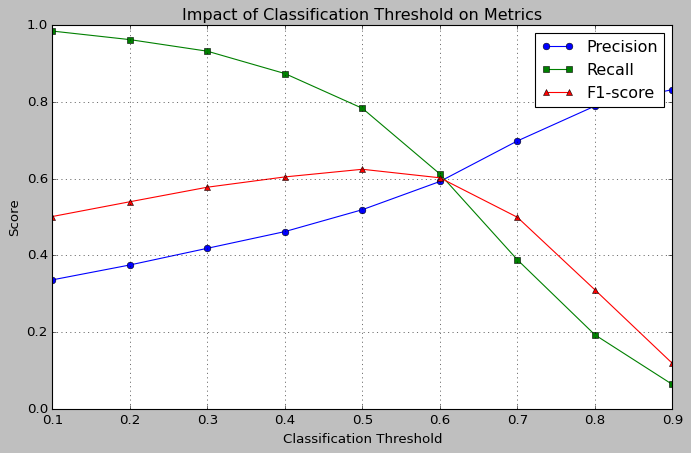


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8203

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.6439

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.50
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.336, Recall=0.984, F1=0.501
   Threshold 0.2: Precision=0.375, Recall=0.962, F1=0.540
   Threshold 0.3: Precision=0.419, Recall=0.932, F1=0.578
   Threshold 0.4: Precision=0.462, Recall=0.874, F1=0.604
   Threshold 0.5: Precision=0.519, Recall=0.783, F1=0.624
   Threshold 0.6: Precision=0.592, Recall=0.612, F1=0.602
   Threshold 0.7: Precision=0.698, Recall=0.389, F1=0.499
   Threshold 0.8: Precision=0.789, Recall=0.193, F1=0.310
   Threshold 0.9: Precision=0.832, Recall=0.064, F1=0.119
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step

Cross-Validation Results:
Accuracy: 0.6649 ± 0.0051
Precision: 0.6133 ± 0.0065
Recall: 0.8939 ± 0.0151
F1: 0.7273 ± 0.0022

Test S

In [9]:
#both Smote and MU-Sigma
# maybe not use this - too many permutations
cv_scores_1d, test_scores_1d, best_cnn_model_1d, history_model_1d = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, 
    augmentation_fn=apply_smote, second_aug_fn=apply_mu_sigma,
    window_size=11, step_size=1
)

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)
Epoch [0/500] | D Loss: 1.3438 | G Loss: 0.6452
Epoch [100/500] | D Loss: 1.2781 | G Loss: 0.6420
Epoch [200/500] | D Loss: 1.2777 | G Loss: 0.6426
Epoch [300/500] | D Loss: 1.2319 | G Loss: 0.6742
Epoch [400/500] | D Loss: 0.9887 | G Loss: 0.8629

==================== Training Set After GAN: apply_gan_augmentation ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0.0: 13989 samples (50.00%)
Class 1.0: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7432 - loss: 0.5760 - val_accuracy: 0.8100 - val_loss: 0.4851
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8029 - loss: 0.4852 - val_accuracy: 0.8095 - val_loss: 0.4750
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8090 - loss: 0.4722 - val_accuracy: 0.8167 - val_loss: 0.4587
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8083 - loss: 0.4708 - val_accuracy: 0.8202 - val_loss: 0.4595
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8196 - loss: 0.4569 - val_accuracy: 0.8310 - val_loss: 0.4555
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8224 - loss: 0.4483 - val_accuracy: 0.8259 - val_loss: 0.4426
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8265 - loss: 0.4378 - val_accuracy: 0.8356 - val_loss: 0.4398
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8316 - loss: 0.4350 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7513 - loss: 0.5585 - val_accuracy: 0.8070 - val_loss: 0.4904
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8024 - loss: 0.4827 - val_accuracy: 0.8138 - val_loss: 0.4775
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8152 - loss: 0.4700 - val_accuracy: 0.8065 - val_loss: 0.4745
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8159 - loss: 0.4612 - val_accuracy: 0.8197 - val_loss: 0.4614
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8207 - loss: 0.4524 - val_accuracy: 0.8274 - val_loss: 0.4533
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8247 - loss: 0.4473 - val_accuracy: 0.8317 - val_loss: 0.4479
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8370 - loss: 0.4310 - val_accuracy: 0.8292 - val_loss: 0.4417
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8290 - loss: 0.4339 - val_ac

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7625 - loss: 0.5572 - val_accuracy: 0.8140 - val_loss: 0.4881
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8037 - loss: 0.4901 - val_accuracy: 0.8099 - val_loss: 0.4767
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8080 - loss: 0.4734 - val_accuracy: 0.8002 - val_loss: 0.4732
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8176 - loss: 0.4610 - val_accuracy: 0.8197 - val_loss: 0.4543
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8241 - loss: 0.4476 - val_accuracy: 0.8236 - val_loss: 0.4594
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8343 - loss: 0.4385 - val_accuracy: 0.8118 - val_loss: 0.4527
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8311 - loss: 0.4380 - val_accuracy: 0.8311 - val_loss: 0.4480
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8400 - loss: 0.4256 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7572 - loss: 0.5465 - val_accuracy: 0.8080 - val_loss: 0.4984
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8080 - loss: 0.4867 - val_accuracy: 0.8073 - val_loss: 0.4807
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8102 - loss: 0.4714 - val_accuracy: 0.8152 - val_loss: 0.4710
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8191 - loss: 0.4634 - val_accuracy: 0.8209 - val_loss: 0.4688
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8205 - loss: 0.4514 - val_accuracy: 0.8259 - val_loss: 0.4591
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8247 - loss: 0.4458 - val_accuracy: 0.8286 - val_loss: 0.4511
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8344 - loss: 0.4289 - val_accuracy: 0.8306 - val_loss: 0.4410
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8332 - loss: 0.4323 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7488 - loss: 0.5656 - val_accuracy: 0.8102 - val_loss: 0.4835
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8042 - loss: 0.4842 - val_accuracy: 0.8184 - val_loss: 0.4748
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8086 - loss: 0.4751 - val_accuracy: 0.8068 - val_loss: 0.4720
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8162 - loss: 0.4628 - val_accuracy: 0.8257 - val_loss: 0.4666
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8215 - loss: 0.4521 - val_accuracy: 0.8282 - val_loss: 0.4563
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8244 - loss: 0.4459 - val_accuracy: 0.8064 - val_loss: 0.4573
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8312 - loss: 0.4363 - val_accuracy: 0.8284 - val_loss: 0.4436
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8291 - loss: 0.4309 - val_acc

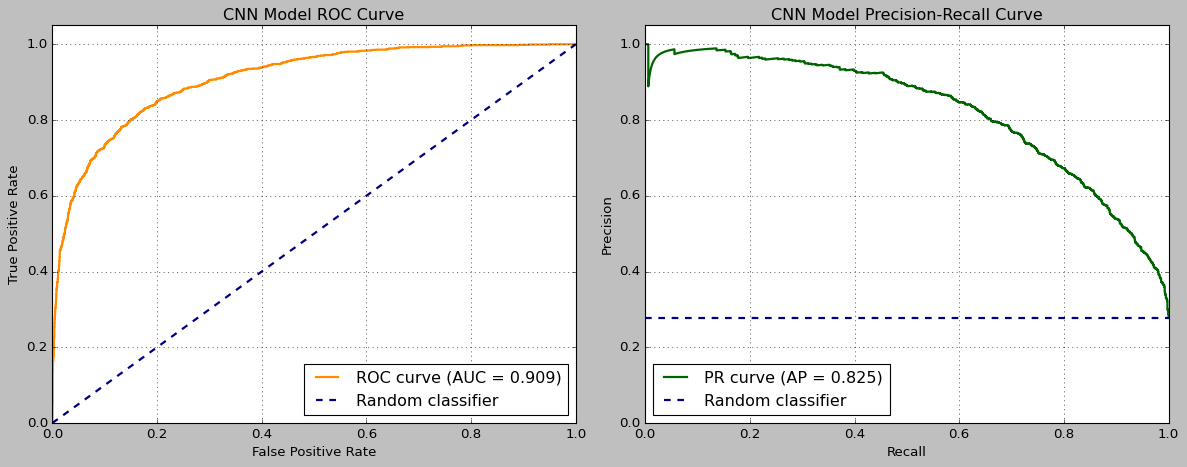

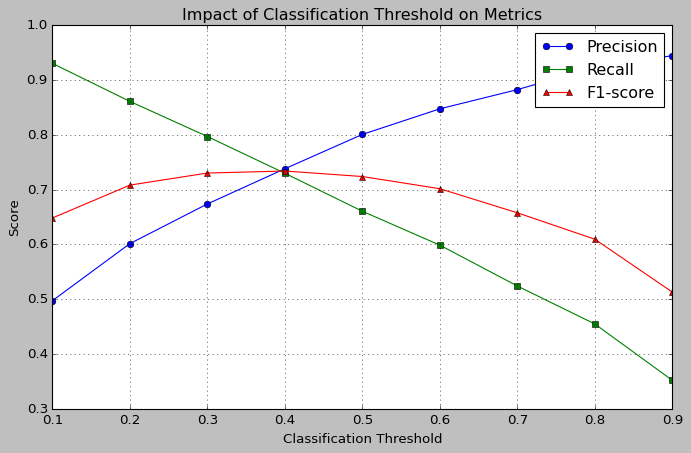


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9094

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8246

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.497, Recall=0.930, F1=0.648
   Threshold 0.2: Precision=0.601, Recall=0.861, F1=0.708
   Threshold 0.3: Precision=0.674, Recall=0.797, F1=0.730
   Threshold 0.4: Precision=0.738, Recall=0.730, F1=0.734
   Threshold 0.5: Precision=0.801, Recall=0.660, F1=0.724
   Threshold 0.6: Precision=0.847, Recall=0.599, F1=0.702
   Threshold 0.7: Precision=0.882, Recall=0.524, F1=0.658
   Threshold 0.8: Precision=0.923, Recall=0.455, F1=0.609
   Threshold 0.9: Precision=0.944, Recall=0.352, F1=0.513
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Cross-Validation Results:
Accuracy: 0.9048 ± 0.0026
Precision: 0.9398 ± 0.0093
Recall: 0.8653 ± 0.0124
F1: 0.9009 ± 0.0034

Test Set

In [27]:
# only gan for augmentation
import torch
import torch.nn as nn
import numpy as np
cv_scores_gan, test_scores_gan, best_cnn_model_gan, history_model_gan = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, 
    augmentation_fn=None, gan_fn=apply_gan_augmentation,
    window_size=11, step_size=1
)

NameError: name 'history_model_gan' is not defined

# corrected T-SMOTE

In [18]:

# corrected tmsmote 

import numpy as np
from typing import Tuple

def temporal_smote(X: np.ndarray, 
                  y: np.ndarray,
                  minority_class_label: int = 1,
                  imbalance_ratio: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Simplified Temporal SMOTE implementation for deep learning preprocessing.
    
    Args:
        X: Input data of shape (n_samples, time_steps, n_features)
        y: Labels array
        minority_class_label: Label of the minority class (default=1)
        imbalance_ratio: Desired ratio between majority and minority classes
        
    Returns:
        Tuple of (resampled features, resampled labels)
    """
    n_samples, time_steps, n_features = X.shape
    
    # Identify minority and majority samples
    minority_mask = y == minority_class_label
    majority_mask = ~minority_mask
    
    X_minority = X[minority_mask]
    X_majority = X[majority_mask]
    
    n_minority = len(X_minority)
    n_majority = len(X_majority)
    
    # Calculate total number of synthetic samples needed
    n_synthetic_total = int(n_majority * imbalance_ratio - n_minority)
    
    if n_synthetic_total <= 0:
        return X, y
    
    # Initialize lists for synthetic samples
    synthetic_samples = []
    
    # Generate synthetic samples using temporal neighbors
    for i in range(len(X_minority) - 1):
        # Current sample and its temporal neighbor (next time step)
        current_sample = X_minority[i]
        temporal_neighbor = X_minority[i + 1]
        
        # Calculate number of synthetic samples for this instance
        # Distribute synthetic samples equally among minority instances
        n_synthetic = n_synthetic_total // (len(X_minority) - 1)
        if i < n_synthetic_total % (len(X_minority) - 1):
            n_synthetic += 1
        
        # Generate synthetic samples
        for _ in range(n_synthetic):
            # Generate alpha using Beta distribution
            # Using fixed parameters (0.5, 0.5) for uniform interpolation
            # You can adjust these parameters based on your needs
            alpha = np.random.beta(0.5, 0.5)
            
            # Generate synthetic sample
            synthetic = alpha * current_sample + (1 - alpha) * temporal_neighbor
            synthetic_samples.append(synthetic)
    
    # Convert lists to arrays
    if synthetic_samples:
        synthetic_samples = np.array(synthetic_samples)
        synthetic_labels = np.full(len(synthetic_samples), minority_class_label)
        
        # Combine original and synthetic data
        X_resampled = np.vstack((X, synthetic_samples))
        y_resampled = np.hstack((y, synthetic_labels))
    else:
        X_resampled = X
        y_resampled = y
    
    return X_resampled, y_resampled
    
    
cv_scores_tsmote, test_scores_tsmote, best_cnn_model_tsmote, history_model_tsmote = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=temporal_smote, 
    window_size=11, step_size=1
)



using stratify=labels
Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
current n_window size 19360
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After temporal_smote ====================
current n_window size 27978
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5435 - loss: 0.8300 - val_accuracy: 0.6385 - val_loss: 0.7556
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6535 - loss: 0.7549 - val_accuracy: 0.6816 - val_loss: 0.6967
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6856 - loss: 0.7002 - val_accuracy: 0.6603 - val_loss: 0.6770
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7184 - loss: 0.6562 - val_accuracy: 0.7293 - val_loss: 0.6242
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7306 - loss: 0.6318 - val_accuracy: 0.7339 - val_loss: 0.6012
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7432 - loss: 0.6048 - val_accuracy: 0.7584 - val_loss: 0.5809
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7594 - loss: 0.5841 - val_accuracy: 0.7748 - val_loss: 0.5574
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7648 - loss: 0.5662 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5504 - loss: 0.8231 - val_accuracy: 0.5940 - val_loss: 0.7727
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6443 - loss: 0.7582 - val_accuracy: 0.6891 - val_loss: 0.7174
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6856 - loss: 0.7050 - val_accuracy: 0.6692 - val_loss: 0.6827
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7086 - loss: 0.6631 - val_accuracy: 0.7395 - val_loss: 0.6267
Epoch 5/100
512/700 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7300 - loss: 0.6344

KeyboardInterrupt: 

Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training Set After t_smote_3d ====================
Dataset shape: (27978, 11, 9)
Labels shape: (27978,)

Class Distribution:
-----------------
Class 0: 13989 samples (50.00%)
Class 1: 13989 samples (50.00%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5449 - loss: 0.8244 - val_accuracy: 0.6160 - val_loss: 0.7863
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6101 - loss: 0.7831 - val_accuracy: 0.6539 - val_loss: 0.7603
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6460 - loss: 0.7551 - val_accuracy: 0.6762 - val_loss: 0.7164
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6662 - loss: 0.7294 - val_accuracy: 0.6835 - val_loss: 0.7031
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6800 - loss: 0.7046 - val_accuracy: 0.6964 - val_loss: 0.6713
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7049 - loss: 0.6808 - val_accuracy: 0.7169 - val_loss: 0.6537
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7226 - loss: 0.6475 - val_accuracy: 0.7268 - val_loss: 0.6334
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7352 - loss: 0.6286 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5330 - loss: 0.8275 - val_accuracy: 0.6374 - val_loss: 0.7755
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6224 - loss: 0.7761 - val_accuracy: 0.6755 - val_loss: 0.7459
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6561 - loss: 0.7436 - val_accuracy: 0.6651 - val_loss: 0.7170
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6739 - loss: 0.7184 - val_accuracy: 0.6900 - val_loss: 0.6850
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7031 - loss: 0.6850 - val_accuracy: 0.7287 - val_loss: 0.6675
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7163 - loss: 0.6631 - val_accuracy: 0.7250 - val_loss: 0.6381
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7177 - loss: 0.6475 - val_accuracy: 0.7505 - val_loss: 0.6139
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7393 - loss: 0.6221 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5385 - loss: 0.8241 - val_accuracy: 0.6022 - val_loss: 0.7774
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6241 - loss: 0.7733 - val_accuracy: 0.6206 - val_loss: 0.7558
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6628 - loss: 0.7350 - val_accuracy: 0.6651 - val_loss: 0.7228
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6858 - loss: 0.7057 - val_accuracy: 0.7010 - val_loss: 0.6891
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7053 - loss: 0.6761 - val_accuracy: 0.7185 - val_loss: 0.6687
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7196 - loss: 0.6519 - val_accuracy: 0.7414 - val_loss: 0.6404
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7354 - loss: 0.6306 - val_accuracy: 0.7343 - val_loss: 0.6229
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7469 - loss: 0.6065 - val_accuracy: 0.7614

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5425 - loss: 0.8250 - val_accuracy: 0.6204 - val_loss: 0.7804
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6218 - loss: 0.7758 - val_accuracy: 0.6495 - val_loss: 0.7469
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6558 - loss: 0.7416 - val_accuracy: 0.6463 - val_loss: 0.7252
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6744 - loss: 0.7189 - val_accuracy: 0.6897 - val_loss: 0.7025
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6900 - loss: 0.6953 - val_accuracy: 0.7153 - val_loss: 0.6833
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7148 - loss: 0.6647 - val_accuracy: 0.7253 - val_loss: 0.6573
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7249 - loss: 0.6414 - val_accuracy: 0.7305 - val_loss: 0.6439
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7386 - loss: 0.6216 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5367 - loss: 0.8262 - val_accuracy: 0.6261 - val_loss: 0.7926
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6227 - loss: 0.7752 - val_accuracy: 0.6366 - val_loss: 0.7599
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6460 - loss: 0.7492 - val_accuracy: 0.6674 - val_loss: 0.7307
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6747 - loss: 0.7200 - val_accuracy: 0.6969 - val_loss: 0.7110
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6958 - loss: 0.6894 - val_accuracy: 0.7215 - val_loss: 0.6899
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7130 - loss: 0.6643 - val_accuracy: 0.7137 - val_loss: 0.6600
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7280 - loss: 0.6381 - val_accuracy: 0.7380 - val_loss: 0.6392
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7291 - loss: 0.6355 - val_ac

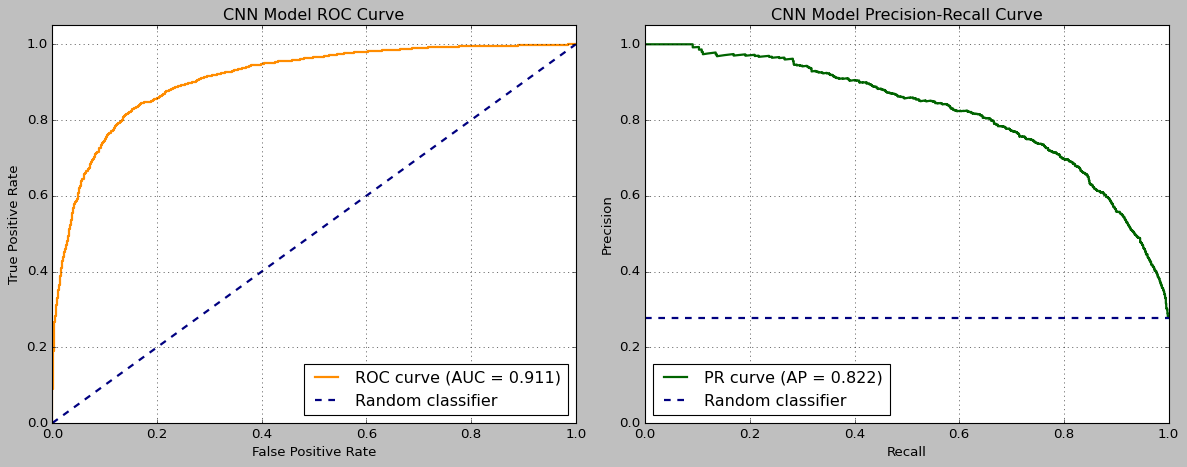

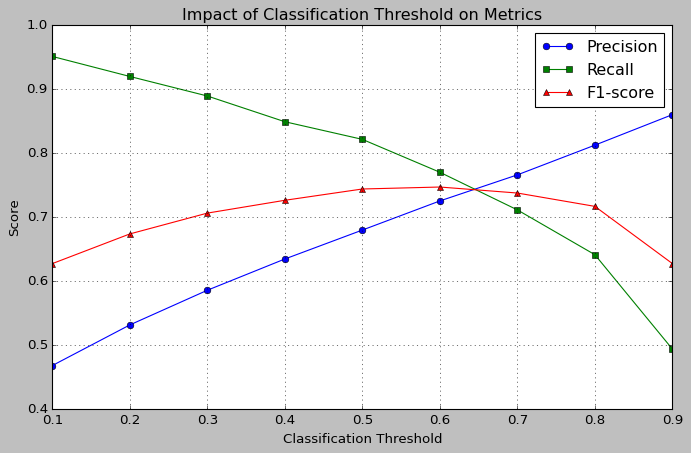


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.9106

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8222

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.60
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.468, Recall=0.951, F1=0.627
   Threshold 0.2: Precision=0.531, Recall=0.920, F1=0.674
   Threshold 0.3: Precision=0.586, Recall=0.889, F1=0.706
   Threshold 0.4: Precision=0.634, Recall=0.849, F1=0.726
   Threshold 0.5: Precision=0.680, Recall=0.821, F1=0.744
   Threshold 0.6: Precision=0.725, Recall=0.770, F1=0.747
   Threshold 0.7: Precision=0.766, Recall=0.711, F1=0.737
   Threshold 0.8: Precision=0.812, Recall=0.641, F1=0.717
   Threshold 0.9: Precision=0.860, Recall=0.494, F1=0.627
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Cross-Validation Results:
Accuracy: 0.8962 ± 0.0095
Precision: 0.8545 ± 0.0142
Recall: 0.9554 ± 0.0070
F1: 0.9020 ± 0.0082

Test Set

In [28]:
# wrong
import numpy as np
from sklearn.neighbors import NearestNeighbors

import numpy as np
from sklearn.neighbors import NearestNeighbors

# minority = falls (1)
def t_smote_3d(X, y, minority_class_label=1, target_ratio=1.0, n_neighbors=5, beta=0.5):
    """
    T-SMOTE implementation for 3D time-series data with manual minority class definition.

    Args:
        X (numpy.ndarray): Feature matrix (n_samples, time_steps, n_features).
        y (numpy.ndarray): Labels.
        minority_class_label (int): Label of the minority class to be oversampled.
        n_neighbors (int): Number of temporal neighbors.
        beta (float): Beta distribution parameter for interpolation.

    Returns:
        X_new, y_new: Resampled feature matrix and labels.
    """
    n_samples, time_steps, n_features = X.shape

    # Reshape to 2D: (n_samples, time_steps * n_features)
    X_reshaped = X.reshape(n_samples, -1)

    # Select minority class samples
    X_minority = X_reshaped[y == minority_class_label]
    X_majority = X_reshaped[y != minority_class_label] # class 0

    n_minority = X_minority.shape[0]
    n_majority = X_majority.shape[0]

    # Calculate the number of synthetic samples needed
    n_synthetic = int(n_majority * target_ratio - n_minority)
    if n_synthetic <= 0:
        print("No oversampling needed. Returning original dataset.")
        return X, y

    # Adjust n_neighbors if needed
    n_neighbors = min(n_neighbors, n_minority - 1)
    temporal_neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(X_minority)

    # Generate synthetic samples
    X_synthetic = []
    for _ in range(n_synthetic):
        # Randomly select a minority sample and find its neighbors
        idx = np.random.randint(0, n_minority)
        neighbors = temporal_neighbors.kneighbors([X_minority[idx]], return_distance=False)[0]
        neighbor = X_minority[np.random.choice(neighbors)]

        # Interpolate between the selected sample and its neighbor
        alpha = np.random.beta(beta, 1 - beta)
        synthetic = alpha * X_minority[idx] + (1 - alpha) * neighbor
        X_synthetic.append(synthetic)


    X_synthetic = np.array(X_synthetic)
    # Reshape synthetic samples back to 3D
    X_synthetic_3d = X_synthetic.reshape(-1, time_steps, n_features)
    # Create labels for synthetic samples
    y_synthetic = np.full(X_synthetic_3d.shape[0], minority_class_label)
    # Combine original and synthetic data
    X_resampled = np.vstack((X, X_synthetic_3d))
    y_resampled = np.hstack((y, y_synthetic))
    return X_resampled, y_resampled


# Example usage
# X_train = np.random.rand(19360, 11, 9)  # Example 3D data
# y_train = np.concatenate((np.ones(1000), np.zeros(18360)))  # Imbalanced labels
# Manually define the minority class as label 1
# X_resampled, y_resampled = t_smote_3d(X_train, y_train, minority_class_label=1)

# print(f'Resampled data shape: {X_resampled.shape}, Resampled labels shape: {y_resampled.shape}')

cv_scores_tsmote, test_scores_tsmote, best_cnn_model_tsmote, history_model_tsmote = kfold_model_performance(
    final_df_ambient, build_model_fn=build_1d_cnn, augmentation_fn=t_smote_3d, 
    window_size=11, step_size=1
)


cnn, normal kfold 

Cross-Validation Results:
Accuracy: 0.8951 ± 0.0038
Precision: 0.8588 ± 0.0166
Recall: 0.9465 ± 0.0184
F1: 0.9002 ± 0.0027

Test Set Results (Best Model):
Accuracy: 0.8506
Precision: 0.6945
Recall: 0.7317
F1: 0.7126

Confusion Matrix:
[[3526  432]
 [ 360  982]]


In [ ]:
# def build_1d_cnn_unbiased(input_shape, optimizer='adam', filters=64, kernel_size=3, l2_lambda=0.0001):
#     model = Sequential()
#     model.add(Conv1D(filters=128, kernel_size=kernel_size, activation='relu',
#                      input_shape=input_shape,
#                      kernel_regularizer=l2(l2_lambda)))
#     model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu',
#                      kernel_regularizer=l2(l2_lambda)))
#     model.add(Dropout(0.5))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(1, activation='sigmoid')) # binary
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model



Training set shape: (19360, 11, 9), Test set shape: (4841, 11, 9)
Test set class distribution: Counter({0: 3498, 1: 1343})

==================== Training Set Before Augmentation ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

==================== Training set: NO Sampling ====================
Dataset shape: (19360, 11, 9)
Labels shape: (19360,)

Class Distribution:
-----------------
Class 0: 13989 samples (72.26%)
Class 1: 5371 samples (27.74%)

Fold 1/5


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6885 - loss: 0.7530 - val_accuracy: 0.7149 - val_loss: 0.7054
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7153 - loss: 0.6973 - val_accuracy: 0.7193 - val_loss: 0.6862
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7168 - loss: 0.6833 - val_accuracy: 0.7244 - val_loss: 0.6815
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7285 - loss: 0.6737 - val_accuracy: 0.7386 - val_loss: 0.6681
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7350 - loss: 0.6556 - val_accuracy: 0.7392 - val_loss: 0.6583
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7459 - loss: 0.6376 - val_accuracy: 0.7523 - val_loss: 0.6507
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7641 - loss: 0.6135 - val_accuracy: 0.7446 - val_loss: 0.6408
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7541 - loss: 0.6173 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7115 - loss: 0.7437 - val_accuracy: 0.7175 - val_loss: 0.7091
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7159 - loss: 0.7009 - val_accuracy: 0.7105 - val_loss: 0.6863
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7233 - loss: 0.6797 - val_accuracy: 0.7244 - val_loss: 0.6799
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7426 - loss: 0.6598 - val_accuracy: 0.7373 - val_loss: 0.6667
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7312 - loss: 0.6570 - val_accuracy: 0.7350 - val_loss: 0.6642
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7475 - loss: 0.6387 - val_accuracy: 0.7417 - val_loss: 0.6513
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7535 - loss: 0.6293 - val_accuracy: 0.7430 - val_loss: 0.6445
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7576 - loss: 0.6119 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7012 - loss: 0.7548 - val_accuracy: 0.7206 - val_loss: 0.7176
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7179 - loss: 0.7077 - val_accuracy: 0.7224 - val_loss: 0.6937
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7204 - loss: 0.6839 - val_accuracy: 0.7368 - val_loss: 0.6792
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7300 - loss: 0.6757 - val_accuracy: 0.7368 - val_loss: 0.6794
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7410 - loss: 0.6512 - val_accuracy: 0.7410 - val_loss: 0.6597
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7438 - loss: 0.6432 - val_accuracy: 0.7371 - val_loss: 0.6511
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7440 - loss: 0.6370 - val_accuracy: 0.7554 - val_loss: 0.6472
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7538 - loss: 0.6194 - val_accuracy: 0.7402

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6930 - loss: 0.7568 - val_accuracy: 0.7206 - val_loss: 0.7165
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7087 - loss: 0.7032 - val_accuracy: 0.6878 - val_loss: 0.7059
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7051 - loss: 0.6935 - val_accuracy: 0.7451 - val_loss: 0.6858
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7256 - loss: 0.6701 - val_accuracy: 0.7500 - val_loss: 0.6747
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7413 - loss: 0.6511 - val_accuracy: 0.7373 - val_loss: 0.6664
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7420 - loss: 0.6466 - val_accuracy: 0.7459 - val_loss: 0.6689
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7502 - loss: 0.6271 - val_accuracy: 0.7451 - val_loss: 0.6539
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7537 - loss: 0.6189 - val_accuracy: 0.7611

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


484/484 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6935 - loss: 0.7534 - val_accuracy: 0.7159 - val_loss: 0.7004
Epoch 2/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7134 - loss: 0.7025 - val_accuracy: 0.7203 - val_loss: 0.6806
Epoch 3/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7244 - loss: 0.6748 - val_accuracy: 0.7180 - val_loss: 0.6745
Epoch 4/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7298 - loss: 0.6647 - val_accuracy: 0.7417 - val_loss: 0.6659
Epoch 5/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7469 - loss: 0.6441 - val_accuracy: 0.7348 - val_loss: 0.6492
Epoch 6/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7485 - loss: 0.6381 - val_accuracy: 0.7348 - val_loss: 0.6423
Epoch 7/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7487 - loss: 0.6355 - val_accuracy: 0.7485 - val_loss: 0.6338
Epoch 8/100
484/484 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7682 - loss: 0.6062 - val_accuracy: 0.7601

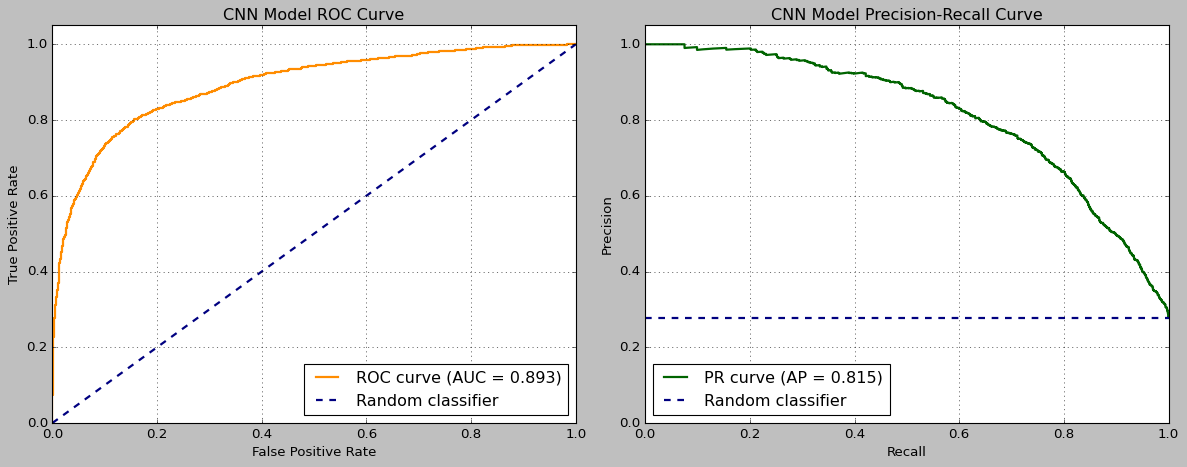

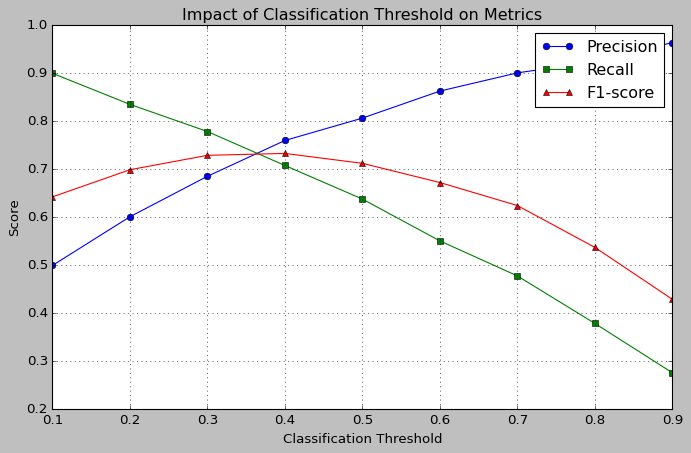


    Advanced Model Evaluation Results

    1. ROC Analysis:
    - Area Under ROC Curve (AUC): 0.8935

    2. Precision-Recall Analysis:
    - Average Precision (AP): 0.8148

    3. Threshold Analysis:
    Optimal threshold based on F1-score: 0.40
    
    Performance at different thresholds:
    
   Threshold 0.1: Precision=0.499, Recall=0.899, F1=0.642
   Threshold 0.2: Precision=0.600, Recall=0.835, F1=0.698
   Threshold 0.3: Precision=0.685, Recall=0.778, F1=0.728
   Threshold 0.4: Precision=0.759, Recall=0.707, F1=0.732
   Threshold 0.5: Precision=0.806, Recall=0.637, F1=0.712
   Threshold 0.6: Precision=0.862, Recall=0.550, F1=0.672
   Threshold 0.7: Precision=0.900, Recall=0.477, F1=0.624
   Threshold 0.8: Precision=0.924, Recall=0.378, F1=0.537
   Threshold 0.9: Precision=0.964, Recall=0.276, F1=0.428
    
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Cross-Validation Results:
Accuracy: 0.8600 ± 0.0047
Precision: 0.8014 ± 0.0117
Recall: 0.6589 ± 0.0158
F1: 0.7231 ± 0.0107

Test Set

In [32]:
# from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
# from sklearn.utils.class_weight import compute_class_weight
# from collections import Counter

# # def kfold_model_performance_new(data, build_model_fn=None, augmentation_fn=None, 
#                             second_aug_fn=None, gan_fn=None, window_size=11, 
#                             step_size=1, n_splits=5, epochs=100):
  
#     # Preprocess data: Generate sliding windows and labels
#     windows, labels = create_sliding_windows2(data, window_size=window_size, step_size=step_size)

#     # Step 1: Stratified train/test split to ensure balanced class distribution
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#     train_idx, test_idx = next(sss.split(windows, labels))

#     X_train, X_test = windows[train_idx], windows[test_idx]
#     y_train, y_test = labels[train_idx], labels[test_idx]

#     print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
#     print(f"Test set class distribution: {Counter(y_test)}")
#     print_window_dataset_info(X_train, y_train, "Training Set Before Augmentation")

#     # Step 2: Apply augmentation or oversampling on the training data
#     if augmentation_fn:
#         X_train_resampled, y_train_resampled = augmentation_fn(X_train, y_train)
#         desc = f"Training Set After {augmentation_fn.__name__}"
#     else:
#         X_train_resampled, y_train_resampled = X_train, y_train
#         desc = "Training set: NO Sampling"

#     if second_aug_fn:
#         X_train_resampled, y_train_resampled = second_aug_fn(X_train_resampled, y_train_resampled)
#         desc = f"Training Set After {second_aug_fn.__name__}"

#     if gan_fn:
#         X_train_resampled, y_train_resampled = apply_gan_augmentation(X_train_resampled, y_train_resampled)
#         desc = f"Training Set After GAN: {gan_fn.__name__}"

#     print_window_dataset_info(X_train_resampled, y_train_resampled, desc)

#     # Compute class weights to handle class imbalance
#     # class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), 
#     #                                      y=y_train_resampled)
#     # class_weight_dict = dict(enumerate(class_weights))

#     # Step 3: Stratified K-Fold Cross-Validation
#     kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     cv_scores = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1']}
    
#     best_model = None
#     best_val_score = 0

#     for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_resampled, y_train_resampled)):
#         print(f"\nFold {fold + 1}/{n_splits}")
#         X_fold_train, X_fold_val = X_train_resampled[train_idx], X_train_resampled[val_idx]
#         y_fold_train, y_fold_val = y_train_resampled[train_idx], y_train_resampled[val_idx]

#         # Step 4: Build and compile the model
#         input_shape = (X_train_resampled.shape[1], X_train_resampled.shape[2])
#         model = build_model_fn(input_shape=input_shape)
        
#         history = model.fit(
#             X_fold_train, y_fold_train,
#             validation_data=(X_fold_val, y_fold_val),
#             epochs=epochs,
#             batch_size=32,
#             # class_weight=class_weight_dict,  # Use class weights
#             verbose=1
#         )

#         y_val_pred = (model.predict(X_fold_val) > 0.5).astype(int)
#         val_acc = accuracy_score(y_fold_val, y_val_pred)

#         # Record metrics
#         cv_scores['accuracy'].append(val_acc)
#         cv_scores['precision'].append(precision_score(y_fold_val, y_val_pred))
#         cv_scores['recall'].append(recall_score(y_fold_val, y_val_pred))
#         cv_scores['f1'].append(f1_score(y_fold_val, y_val_pred))

#         if val_acc > best_val_score:
#             best_val_score = val_acc
#             best_model = model

#     # Evaluate the best model on the test set
#     roc_auc, avg_precision, threshold_results = evaluate_model_advanced(best_model, X_test, y_test)
#     thres = find_optimal_threshold(threshold_results)

#     y_test_pred = (best_model.predict(X_test) > thres).astype(int)
#     test_metrics = {
#         'accuracy': accuracy_score(y_test, y_test_pred),
#         'precision': precision_score(y_test, y_test_pred),
#         'recall': recall_score(y_test, y_test_pred),
#         'f1': f1_score(y_test, y_test_pred)
#     }

#     # Display cross-validation results
#     print("\nCross-Validation Results:")
#     for metric in cv_scores:
#         mean, std = np.mean(cv_scores[metric]), np.std(cv_scores[metric])
#         print(f"{metric.title()}: {mean:.4f} ± {std:.4f}")

#     # Display test set results
#     print("\nTest Set Results (Best Model):")
#     for metric, value in test_metrics.items():
#         print(f"{metric.title()}: {value:.4f}")

#     print("\nConfusion Matrix:")
#     print(confusion_matrix(y_test, y_test_pred))

#     print("\nClassification Report:")
#     print(classification_report(y_test, y_test_pred))

#     return cv_scores, test_metrics, best_model, history


# # cv_scores_none1, test_scores_none1, best_cnn_model_none1, history_model_none1 = kfold_model_performance_new(
# #     final_df_ambient, 
# #     build_model_fn=build_1d_cnn, 
# #     augmentation_fn=None, 
# #     window_size=11, step_size=1
# # )


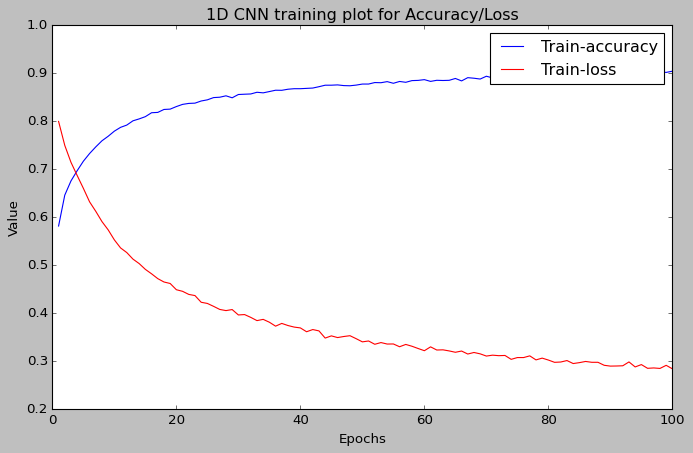

In [63]:

def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_training_history(history):
    # Extract accuracy and loss from the history object
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs = range(1, len(acc) + 1)  # x-axis (number of epochs)

    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot training accuracy
    plt.plot(epochs, acc, 'b-', label='Train-accuracy')

    # Plot training loss
    plt.plot(epochs, loss, 'r-', label='Train-loss')

    # Add title and labels
    plt.title('1D CNN training plot for Accuracy/Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Value')

    # Add legend
    plt.legend()

    # Display the plot
    plt.show()
# plot_training_history(cnn_model_history)

In [68]:
def build_cnn_model_2(input_shape, optimizer='adam', filters=32, kernel_size=3, learning_rate=0.001, l2_lambda=0.0001):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                    #  input_shape=(window_size, X_train.shape[2]),
                     input_shape=input_shape,
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                     kernel_regularizer=l2(l2_lambda)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    if optimizer.lower() == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = optimizer
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [1]:
# plot_class_distribution(df_clean) # no fitlering activties out (very large imbalance)
# final_df_clean
# cv_scores_1a, test_scores_1a, best_cnn_model_1a, history_model_1a = kfold_model_performance(
#     df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_smote, 
#     window_size=10, step_size=1
# )
# plot_performance(history_model_1a)

NameError: name 'kfold_model_performance' is not defined

Training set: (16748, 10, 8), Validation set: (2093, 10, 8), Test set: (2094, 10, 8)
Training set shape: (16748, 10, 8), Test set shape: (2094, 10, 8)
Data after SMOTE: 23206 samples

Fold 1/5
Epoch 1/100


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5362 - loss: 0.8838 - val_accuracy: 0.6370 - val_loss: 0.6622
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5945 - loss: 0.6908 - val_accuracy: 0.6577 - val_loss: 0.6486
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6210 - loss: 0.6681 - val_accuracy: 0.6738 - val_loss: 0.6323
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6429 - loss: 0.6509 - val_accuracy: 0.6818 - val_loss: 0.6198
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6570 - loss: 0.6397 - val_accuracy: 0.6963 - val_loss: 0.6118
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6649 - loss: 0.6356 - val_accuracy: 0.6984 - val_loss: 0.6020
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6699 - loss: 0.6261 - val_accuracy: 0.7038 - val_loss: 0.5958
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6819 - loss: 0.6197 - val_accuracy: 0.7124

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5331 - loss: 0.8557 - val_accuracy: 0.6290 - val_loss: 0.6661
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6019 - loss: 0.6831 - val_accuracy: 0.6499 - val_loss: 0.6495
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6324 - loss: 0.6604 - val_accuracy: 0.6619 - val_loss: 0.6368
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6574 - loss: 0.6405 - val_accuracy: 0.6768 - val_loss: 0.6178
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6732 - loss: 0.6210 - val_accuracy: 0.6841 - val_loss: 0.6086
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6831 - loss: 0.6177 - val_accuracy: 0.6843 - val_loss: 0.6029
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6905 - loss: 0.6034 - val_accuracy: 0.6871 - val_loss: 0.6018
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6970 - loss: 0.5963 - val_acc

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5297 - loss: 0.9041 - val_accuracy: 0.6421 - val_loss: 0.6621
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5964 - loss: 0.6843 - val_accuracy: 0.6475 - val_loss: 0.6461
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6300 - loss: 0.6590 - val_accuracy: 0.6645 - val_loss: 0.6359
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6575 - loss: 0.6422 - val_accuracy: 0.6794 - val_loss: 0.6157
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6646 - loss: 0.6342 - val_accuracy: 0.6861 - val_loss: 0.6065
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6821 - loss: 0.6170 - val_accuracy: 0.6880 - val_loss: 0.5990
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6810 - loss: 0.6150 - val_accuracy: 0.6979 - val_loss: 0.5894
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6899 - loss: 0.6036 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5286 - loss: 0.8947 - val_accuracy: 0.6240 - val_loss: 0.6600
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6045 - loss: 0.6793 - val_accuracy: 0.6520 - val_loss: 0.6463
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6283 - loss: 0.6636 - val_accuracy: 0.6690 - val_loss: 0.6323
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6516 - loss: 0.6472 - val_accuracy: 0.6811 - val_loss: 0.6226
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6744 - loss: 0.6301 - val_accuracy: 0.6869 - val_loss: 0.6141
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6719 - loss: 0.6230 - val_accuracy: 0.6886 - val_loss: 0.6061
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6790 - loss: 0.6172 - val_accuracy: 0.6966 - val_loss: 0.5965
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6898 - loss: 0.6100 - val_accu

/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5312 - loss: 0.9266 - val_accuracy: 0.6561 - val_loss: 0.6555
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5843 - loss: 0.6964 - val_accuracy: 0.6634 - val_loss: 0.6358
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6303 - loss: 0.6602 - val_accuracy: 0.6787 - val_loss: 0.6218
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6537 - loss: 0.6409 - val_accuracy: 0.6807 - val_loss: 0.6095
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6671 - loss: 0.6339 - val_accuracy: 0.6863 - val_loss: 0.6041
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6817 - loss: 0.6215 - val_accuracy: 0.6945 - val_loss: 0.6006
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6807 - loss: 0.6195 - val_accuracy: 0.7003 - val_loss: 0.5926
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6820 - loss: 0.6104 - val_accu

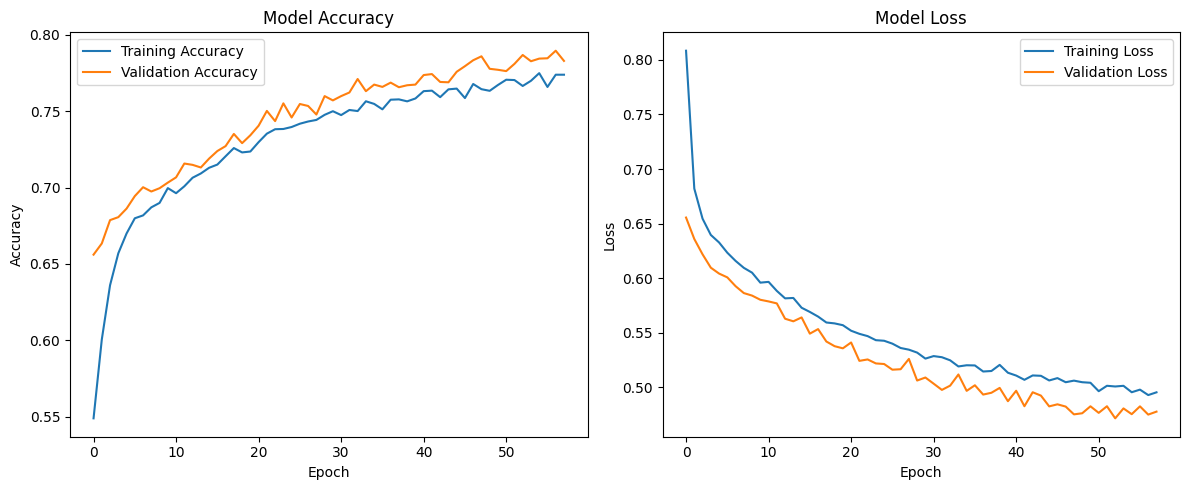

In [71]:
cv_scores_2, test_scores_2, best_cnn_model_2, history_model_2 = kfold_model_performance(
    df_clean, build_model_fn=build_cnn_model_2, augmentation_fn=apply_smote, 
    window_size=10, step_size=1
)
plot_performance(history_model_2)

Training set: (16748, 10, 8), Validation set: (2093, 10, 8), Test set: (2094, 10, 8)
Training set shape: (16748, 10, 8), Test set shape: (2094, 10, 8)


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6693 - loss: 0.7620 - val_accuracy: 0.7086 - val_loss: 0.7001
Epoch 2/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6985 - loss: 0.7097 - val_accuracy: 0.7234 - val_loss: 0.6834
Epoch 3/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7064 - loss: 0.6978 - val_accuracy: 0.7200 - val_loss: 0.6781
Epoch 4/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7096 - loss: 0.6866 - val_accuracy: 0.7267 - val_loss: 0.6702
Epoch 5/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7169 - loss: 0.6818 - val_accuracy: 0.7296 - val_loss: 0.6573
Epoch 6/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7202 - loss: 0.6750 - val_accuracy: 0.7387 - val_loss: 0.6533
Epoch 7/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7201 - loss: 0.6706 - val_accuracy: 0.7344 - val_loss: 0.6532
Epoch 8/100
1571/1571 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7198 - loss:

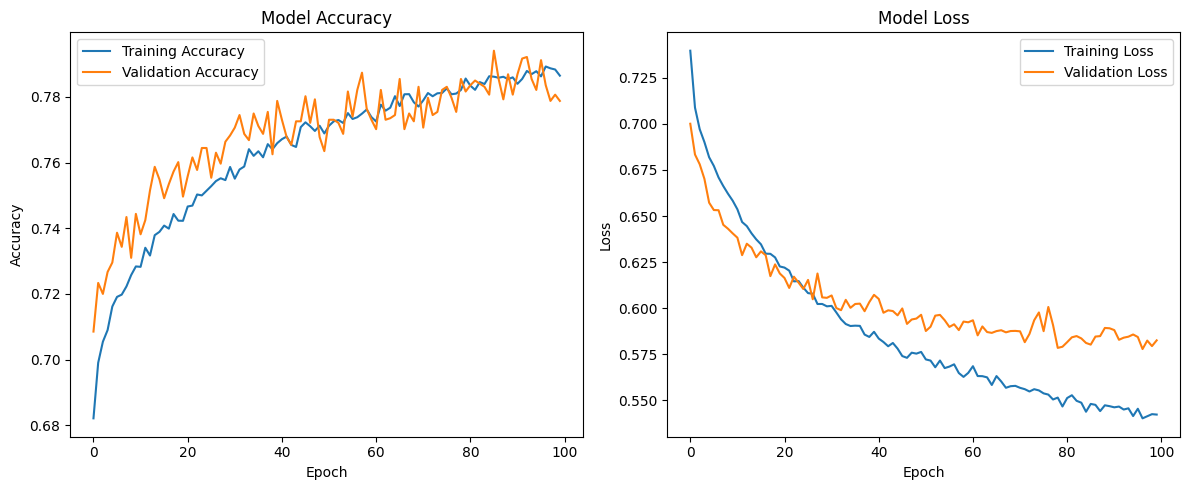

In [73]:
import numpy as np
from typing import Tuple

def augment_training_data(X_train: np.ndarray, y_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augments training data using Mu-Sigma augmentation technique.
    Doubles the training data by creating synthetic signals with added/subtracted noise.
    
    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_timesteps[, n_features])
        y_train (np.ndarray): Training labels
        
    Returns:
        Tuple[np.ndarray, np.ndarray]: Augmented training data and corresponding labels
    """
    # Generate noise for each sample in training data
    noise = np.zeros_like(X_train)
    
    # Calculate noise for each sample independently
    for i in range(len(X_train)):
        # Calculate standard deviation of current sample
        sigma = np.std(X_train[i])
        # Generate noise with zero mean and sample's standard deviation
        noise[i] = np.random.normal(loc=0, scale=sigma, size=X_train[i].shape)
    
    # Create augmented samples
    X_plus_noise = X_train + noise
    X_minus_noise = X_train - noise
    
    # Combine original and augmented data
    X_augmented = np.vstack((X_train, X_plus_noise, X_minus_noise))
    y_augmented = np.concatenate((y_train, y_train, y_train))
    
    # Shuffle the augmented dataset
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented


cnn_model_2, cnn_model_2_history = preprocess_and_train(final_df, 
                                                    build_model_fn=build_1d_cnn,
                                                    augmentation_fn=augment_training_data)
# plot_performance(cnn_model_2_history)
# k fold, using mu0sg

## using GAN augmentation

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def generate_synthetic_time_series(num_samples=100, seq_len=50, noise_dim=100, hidden_dim=64, num_epochs=500):
    """
    Generate synthetic time-series data using a GAN.
    
    Parameters:
    - num_samples: Number of synthetic sequences to generate
    - seq_len: Length of each time-series sequence
    - noise_dim: Dimensionality of the random noise vector
    - hidden_dim: Hidden layer size for both Generator and Discriminator
    - num_epochs: Number of epochs to train the GAN
    
    Returns:
    - X: Synthetic time-series features (num_samples, seq_len)
    - y: Corresponding labels (1 for synthetic, indicating positive class)
    """

    # Define the Generator
    class Generator(nn.Module):
        def __init__(self, noise_dim, hidden_dim, output_dim):
            super(Generator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(noise_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )

        def forward(self, noise):
            return self.model(noise)

    # Define the Discriminator
    class Discriminator(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(Discriminator, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_dim, 1),
                nn.Sigmoid()
            )

        def forward(self, data):
            return self.model(data)

    # Initialize the Generator and Discriminator
    generator = Generator(noise_dim, hidden_dim, seq_len)
    discriminator = Discriminator(seq_len, hidden_dim)

    # Optimizers and loss function
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
    criterion = nn.BCELoss()

    # Function to generate random noise
    def generate_noise(batch_size, noise_dim):
        return torch.randn(batch_size, noise_dim)

    # Train the GAN
    batch_size = 32
    for epoch in range(num_epochs):
        # === Train Discriminator ===
        real_data = torch.randn(batch_size, seq_len)  # Replace with your real data if available
        fake_data = generator(generate_noise(batch_size, noise_dim)).detach()

        # Discriminator loss
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        d_loss_real = criterion(discriminator(real_data), real_labels)
        d_loss_fake = criterion(discriminator(fake_data), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        # Backprop for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # === Train Generator ===
        noise = generate_noise(batch_size, noise_dim)
        generated_data = generator(noise)

        g_loss = criterion(discriminator(generated_data), real_labels)  # Try to fool the discriminator

        # Backprop for Generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print progress every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    # Generate synthetic data
    noise = generate_noise(num_samples, noise_dim)
    synthetic_data = generator(noise).detach().numpy()

    # Generate corresponding labels (1 for synthetic data)
    labels = np.ones(num_samples)

    return synthetic_data, labels

# Example usage:
X, y = generate_synthetic_time_series(num_samples=100, seq_len=50, num_epochs=1000)

# Check the shape of generated data
print(f"Generated Data Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

In [23]:
# cv_scores_3, test_scores_3, best_cnn_model_3, history_model_3 = kfold_model_performance(
#     final_df_clean, build_model_fn=build_1d_cnn, augmentation_fn=apply_mu_sigma, 
#     window_size=11, step_size=1
# )
# plot_performance(history_model_3)

NameError: name 'augment_training_data' is not defined

testing on RF 


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the dataset into X (features) and y (target), 
X = final_df_ambient.drop(['class', 'timestamp', 'activity_name', 'PID', 'base_activity'], axis=1)  # Adjust for your dataset
y = final_df_ambient['class']

# Train/test split with Environmental Index included
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest with Environmental Index
rf_with_index = RandomForestClassifier(n_estimators=100, random_state=42)
rf_with_index.fit(X_train, y_train)
y_pred_with_index = rf_with_index.predict(X_test)

print("With Environmental Index:")
print(classification_report(y_test, y_pred_with_index))

# Remove Environmental Index and retrain the model
# X_no_env = X.drop(['Environmental_Index'], axis=1)  # Adjust column name if needed
X_no_env = final_df_clean.drop(['class', 'timestamp', 'activity_name', 'PID', 'base_activity'], axis=1)
X_train_no_env, X_test_no_env, y_train_no_env, y_test_no_env = train_test_split(X_no_env, y, test_size=0.3, random_state=42)

# Train Random Forest without Environmental Index
rf_no_index = RandomForestClassifier(n_estimators=100, random_state=42)
rf_no_index.fit(X_train_no_env, y_train_no_env)
y_pred_no_index = rf_no_index.predict(X_test_no_env)

print("Without Environmental Index:")
print(classification_report(y_test_no_env, y_pred_no_index))

With Environmental Index:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5748
           1       0.99      0.99      0.99      3186

    accuracy                           0.99      8934
   macro avg       0.99      0.99      0.99      8934
weighted avg       0.99      0.99      0.99      8934

Without Environmental Index:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      5748
           1       0.94      0.92      0.93      3186

    accuracy                           0.95      8934
   macro avg       0.95      0.94      0.95      8934
weighted avg       0.95      0.95      0.95      8934



In [32]:
# !pip install shap
import shap

# If the SHAP summary plot shows that the Environmental 
# Index has an unusually high influence, but domain knowledge 
# suggests it shouldn’t, you have evidence that the feature introduces bias.

# Train the model
rf_with_index.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_with_index)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary of SHAP values
shap.summary_plot(shap_values[1], X_test)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 6.2 MB/s eta 0:00:0000:0100:01


/Users/shingting/Y4/INFO4911/impl/cnn/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 